In [1]:
# ------------------------------------------------
# 
# compare CEC and no CEC runs
# 
# (note, takes
# files that were generated in the scratch/cdr_
# ...feedstock_compare-apprate+psize.ipynb file)
# 
# ------------------------------------------------
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for custom legend entries (needed for contour plot)
import cmocean.cm as cmo
import pickle
import os
import re
import glob
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


# set data path
datpath = "/home/tykukla/aglime-swap-cdr/scepter/process/runs/batch_postprocResults/cc-sil_psize_apprate"


# *** initialize profile vars
varin1 = "adsorbed_percCEC"
varin2 = "aqueous"
varsuff = "batch"
dustsp_sil = "gbas"
dustsp_cc = "cc"


# --- select which data to read in 
# CEC case 1
fertLevel_1 = "hi"
idx_1 = "001" # [(no tag): 009=0.2 ton cc/ha/yr; 012=0.5 ton cc/ha/yr; 002=0.8 ton cc/ha/yr; 011=1.4 ton cc/ha/yr] 
tag_sil_1 = "basev1" # "basev3_multiCTRL"
cectag_forplotting1 = "cecOFF"

# CEC case 2
fertLevel_2 = "hi"
idx_2 = "001" # [(no tag): 009=0.2 ton cc/ha/yr; 012=0.5 ton cc/ha/yr; 002=0.8 ton cc/ha/yr; 011=1.4 ton cc/ha/yr] 
tag_sil_2 = "basev3a"   # "basev3_multiCTRL"
cectag_forplotting2 = "cecON"

In [4]:
# ---- READ IN DATA
# FERT LEVEL 1 
datdir_1 = f"meanAnn_shortRun_{fertLevel_1}Fert_{tag_sil_1}_{idx_1}"    
datloc_1 = os.path.join(datpath, datdir_1)
# read in xr datasets
dssil1 = xr.open_dataset(os.path.join(datloc_1, 'ds_sil.nc'))
dscc1 = xr.open_dataset(os.path.join(datloc_1, 'ds_cc.nc'))
ds_anom1 = xr.open_dataset(os.path.join(datloc_1, 'ds_anom.nc'))
# read in profile data
dssil1_v1 = xr.open_dataset(os.path.join(datloc_1, f"{varin1}_{dustsp_sil}_{varsuff}.nc"))
dscc1_v1 = xr.open_dataset(os.path.join(datloc_1, f"{varin1}_{dustsp_cc}_{varsuff}.nc"))
dssil1_v2 = xr.open_dataset(os.path.join(datloc_1, f"{varin2}_{dustsp_sil}_{varsuff}.nc"))
dscc1_v2 = xr.open_dataset(os.path.join(datloc_1, f"{varin2}_{dustsp_cc}_{varsuff}.nc"))

# FERT LEVEL 2
datdir_2 = f"meanAnn_shortRun_{fertLevel_2}Fert_{tag_sil_2}_{idx_2}"    
datloc_2 = os.path.join(datpath, datdir_2)
# read in xr datasets
dssil2 = xr.open_dataset(os.path.join(datloc_2, 'ds_sil.nc'))
dscc2 = xr.open_dataset(os.path.join(datloc_2, 'ds_cc.nc'))
ds_anom2 = xr.open_dataset(os.path.join(datloc_2, 'ds_anom.nc'))
# read in profile data
dssil2_v1 = xr.open_dataset(os.path.join(datloc_2, f"{varin1}_{dustsp_sil}_{varsuff}.nc"))
dscc2_v1 = xr.open_dataset(os.path.join(datloc_2, f"{varin1}_{dustsp_cc}_{varsuff}.nc"))
dssil2_v2 = xr.open_dataset(os.path.join(datloc_2, f"{varin2}_{dustsp_sil}_{varsuff}.nc"))
dscc2_v2 = xr.open_dataset(os.path.join(datloc_2, f"{varin2}_{dustsp_cc}_{varsuff}.nc"))

## Start with the net removal for basalt and calcite in both CEC cases

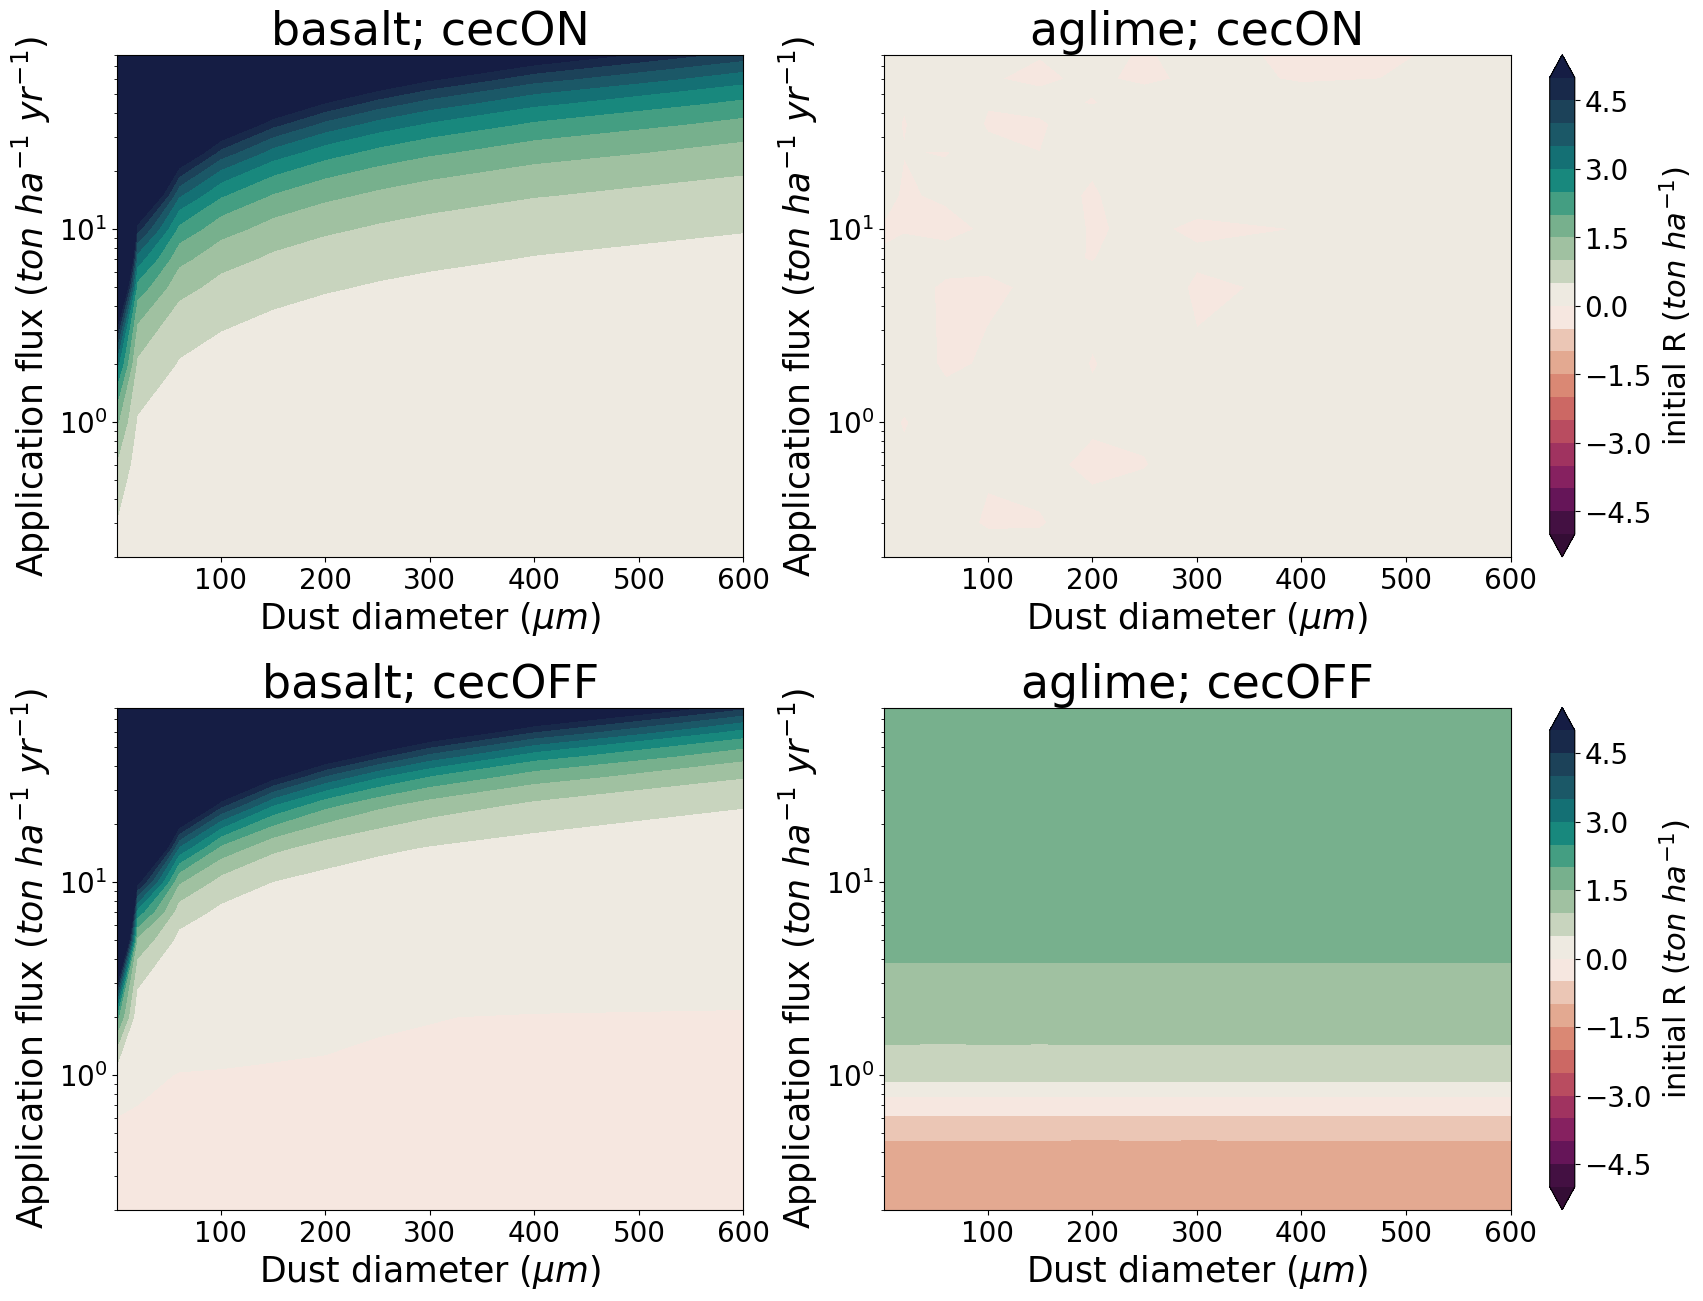

In [5]:
# --- PART 1: 4 panels of basalt and aglime R 
# set data conditions
cdr_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg' 
loss_perc = 0
applevel_show = 12   # [1 | 2 | 12] which fertilizer levels to show
logX = False
logY = True

# pull out the data we want
dssil1_p3 = dssil1.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dscc1_p3 = dscc1.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dssil2_p3 = dssil2.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dscc2_p3 = dscc2.sel(loss_percent = loss_perc, method='nearest')[cdr_var]

# # interpolate to fill nans (they're rare, 
# # but present in a couple cases where a run didn't complete)
dssil1_p3 = dssil1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p3 = dscc1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p3 = dssil2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p3 = dscc2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
include_titles = True
# color palette
col = cmo.curl_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 1), 600
ymin, ymax = (0.2 if logY else 0), 80 
# *****************************

# x and y arrays
# [fertlevel 1, sil]
x1sil = dssil1_p3['dustrad'].values
y1sil = dssil1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 1, cc]
x1cc = dscc1_p3['dustrad'].values
y1cc = dscc1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, sil]
x2sil = dssil2_p3['dustrad'].values
y2sil = dssil2_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, cc]
x2cc = dscc2_p3['dustrad'].values
y2cc = dscc2_p3['dustrate_ton_ha_yr'].values

# update index based on which ferts to show
if applevel_show == 1:
    spec_dx1 = 0
    spec_dx2 = 2
else:
    spec_dx1 = spec_dx2 = 0

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=2, hspace=0.3, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

if (applevel_show == 2) | (applevel_show == 12):
    # --- fertlevel 2 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[0-spec_dx2])
    contour = plt.contourf(x2sil*2,y2sil,dssil2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"Dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"Application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.title(f"basalt; {cectag_forplotting2}", fontsize=fs_title) if include_titles else "")
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    # --- cc
    ax = plt.subplot(spec[1-spec_dx2])
    contour = plt.contourf(x2cc*2,y2cc,dscc2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    # contour_line = plt.contour(x2cc,y2cc,dscc2_p3.transpose(),levels=[0], colors='black', linewidths=2)
    # plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    plt.xlabel(r"Dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"Application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.title(f"aglime; {cectag_forplotting2}", fontsize=fs_title) if include_titles else "")
    cbar = plt.colorbar(contour)
    cbar.set_label(r"initial R $(ton\ ha^{-1})$", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

if (applevel_show == 1) | (applevel_show == 12):
    # --- fertlevel 1 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[2-spec_dx1])
    contour = plt.contourf(x1sil*2,y1sil,dssil1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"Dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"Application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    (plt.title(f"basalt; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    # --- cc
    ax = plt.subplot(spec[3-spec_dx1])
    contour = plt.contourf(x1cc*2,y1cc,dscc1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    # contour_line = plt.contour(x1cc,y1cc,dscc1_p3.transpose(),levels=[0], colors='black', linewidths=2)
    # plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    plt.xlabel(r"Dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"Application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.title(f"aglime; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
    cbar = plt.colorbar(contour)
    cbar.set_label(r"initial R $(ton\ ha^{-1})$", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

In [6]:
# ----

## Compare the cdr potential from alkalinity outflow 

In [7]:
dssil1

<xarray.Dataset> Size: 484kB
Dimensions:                       (loss_percent: 50, dustrate_ton_ha_yr: 14,
                                   dustrad: 10)
Coordinates:
  * loss_percent                  (loss_percent) float64 400B 1.0 3.02 ... 100.0
  * dustrate_ton_ha_yr            (dustrate_ton_ha_yr) float64 112B 0.1 ... 1...
  * dustrad                       (dustrad) int32 40B 1 10 30 50 ... 150 200 300
Data variables: (12/47)
    cdr_dif                       (dustrad, dustrate_ton_ha_yr, loss_percent) float64 56kB ...
    cdr_adv                       (dustrad, dustrate_ton_ha_yr, loss_percent) float64 56kB ...
    cdr_adv_plus_newSIC           (dustrad, dustrate_ton_ha_yr, loss_percent) float64 56kB ...
    cdr_SIConly                   (dustrad, dustrate_ton_ha_yr, loss_percent) float64 56kB ...
    co2pot_tot_tonHa_camg         (dustrad, dustrate_ton_ha_yr, loss_percent) float64 56kB ...
    co2pot_adv_tonHa_camg         (dustrad, dustrate_ton_ha_yr, loss_percent) float64 56kB ...
    ...                            ...
    time_horizon                  float64 8B ...
    truck_km                      float64 8B ...
    barge_km                      float64 8B ...
    barge_diesel_km               int32 4B ...
    p80_input                     float64 8B ...
    bondwork_index                float64 8B ...
Attributes:
    flx_type:  int_flx

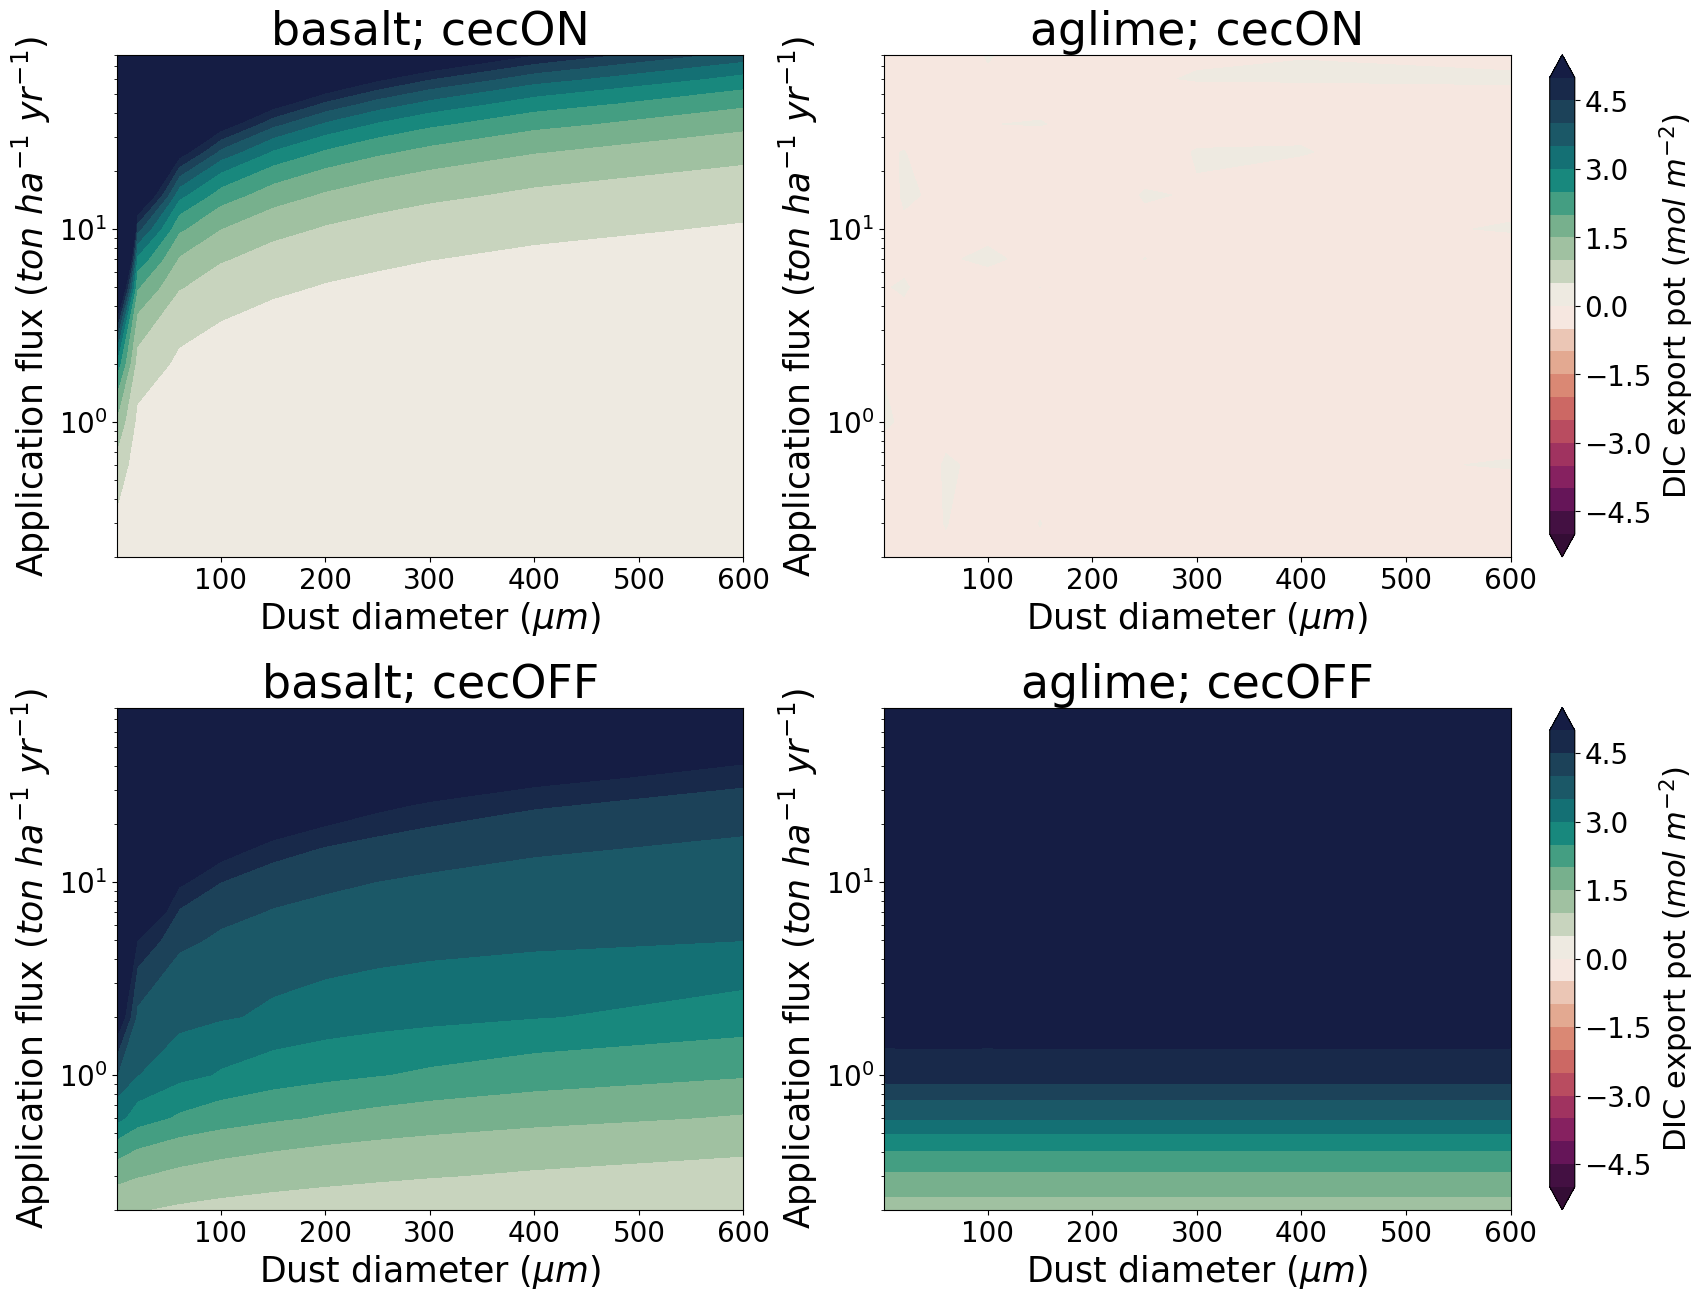

In [8]:
# --- PART 1: 4 panels of basalt and aglime R 
# set data conditions
cdr_var = 'co2pot_adv_tonHa_camg'  # 'co2pot_tot_tonHa_camg'  # 'DICpot_adv_totcat'
loss_perc = 0
applevel_show = 12   # [1 | 2 | 12] which fertilizer levels to show
logX = False
logY = True

# pull out the data we want
dssil1_p3 = dssil1.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dscc1_p3 = dscc1.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dssil2_p3 = dssil2.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dscc2_p3 = dscc2.sel(loss_percent = loss_perc, method='nearest')[cdr_var]

# # interpolate to fill nans (they're rare, 
# # but present in a couple cases where a run didn't complete)
dssil1_p3 = dssil1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p3 = dscc1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p3 = dssil2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p3 = dscc2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
include_titles = True
# color palette
col = cmo.curl_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 1), 600
ymin, ymax = (0.2 if logY else 0), 80 
# *****************************

# x and y arrays
# [fertlevel 1, sil]
x1sil = dssil1_p3['dustrad'].values
y1sil = dssil1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 1, cc]
x1cc = dscc1_p3['dustrad'].values
y1cc = dscc1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, sil]
x2sil = dssil2_p3['dustrad'].values
y2sil = dssil2_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, cc]
x2cc = dscc2_p3['dustrad'].values
y2cc = dscc2_p3['dustrate_ton_ha_yr'].values

# update index based on which ferts to show
if applevel_show == 1:
    spec_dx1 = 0
    spec_dx2 = 2
else:
    spec_dx1 = spec_dx2 = 0

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=2, hspace=0.3, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

if (applevel_show == 2) | (applevel_show == 12):
    # --- fertlevel 2 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[0-spec_dx2])
    contour = plt.contourf(x2sil*2,y2sil,dssil2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"Dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"Application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.title(f"basalt; {cectag_forplotting2}", fontsize=fs_title) if include_titles else "")
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    # --- cc
    ax = plt.subplot(spec[1-spec_dx2])
    contour = plt.contourf(x2cc*2,y2cc,dscc2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    # contour_line = plt.contour(x2cc,y2cc,dscc2_p3.transpose(),levels=[0], colors='black', linewidths=2)
    # plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    plt.xlabel(r"Dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"Application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.title(f"aglime; {cectag_forplotting2}", fontsize=fs_title) if include_titles else "")
    cbar = plt.colorbar(contour)
    cbar.set_label(r"DIC export pot $(mol\ m^{-2})$", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

if (applevel_show == 1) | (applevel_show == 12):
    # --- fertlevel 1 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[2-spec_dx1])
    contour = plt.contourf(x1sil*2,y1sil,dssil1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"Dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"Application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    (plt.title(f"basalt; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    # --- cc
    ax = plt.subplot(spec[3-spec_dx1])
    contour = plt.contourf(x1cc*2,y1cc,dscc1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    # contour_line = plt.contour(x1cc,y1cc,dscc1_p3.transpose(),levels=[0], colors='black', linewidths=2)
    # plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    plt.xlabel(r"Dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"Application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.title(f"aglime; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
    cbar = plt.colorbar(contour)
    cbar.set_label(r"DIC export pot $(mol\ m^{-2})$", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

In [9]:
# ----

## compare fraction of rock that dissolves

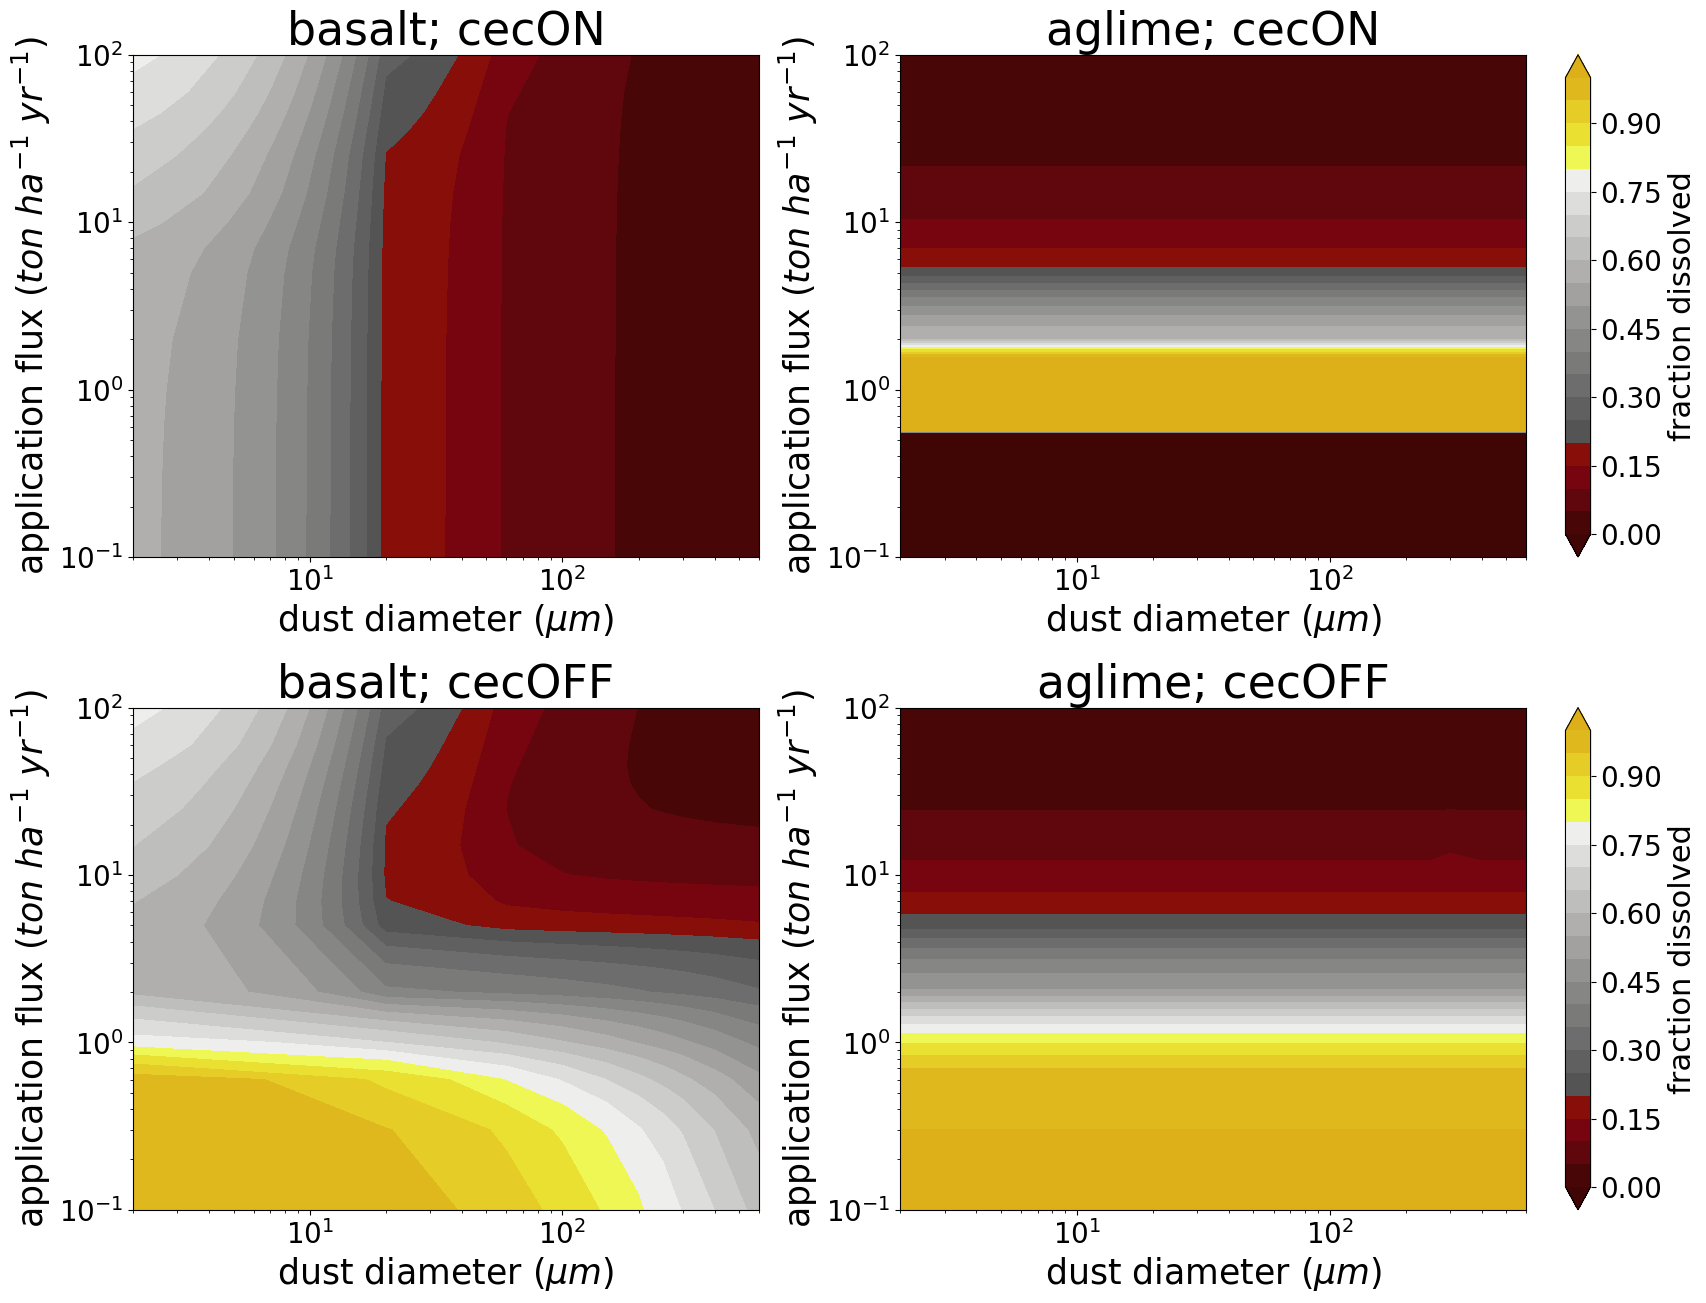

In [10]:
# --- PLOT --------------------
# set data conditions
pvar = 'fraction_remaining_dissolved' # 'fraction_total_dissolved'
fertlevel_show = 12   # [1 | 2 | 12]
logX = True
logY = True

# pull out the data we want
dssil1_p3 = dssil1[pvar]
dssil2_p3 = dssil2[pvar]
dscc1_p3 = dscc1[pvar]
dscc2_p3 = dscc2[pvar]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dssil1_p3 = dssil1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p3 = dssil2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p3 = dscc1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p3 = dscc2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
include_titles = True
# color palette
col = cmo.oxy
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = 0, 1
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60
# *****************************

# x and y arrays
# [fertlevel 1, sil]
x1sil = dssil1_p3['dustrad'].values
y1sil = dssil1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 1, cc]
x1cc = dscc1_p3['dustrad'].values
y1cc = dscc1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, sil]
x2sil = dssil2_p3['dustrad'].values
y2sil = dssil2_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, cc]
x2cc = dscc1_p3['dustrad'].values
y2cc = dscc1_p3['dustrate_ton_ha_yr'].values

# update index based on which ferts to show
if fertlevel_show == 1:
    spec_dx1 = 0
    spec_dx2 = 2
else:
    spec_dx1 = spec_dx2 = 0

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=2, hspace=0.3, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

if (fertlevel_show == 2) | (fertlevel_show == 12):
    # --- fertlevel 2 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[0-spec_dx2])
    contour = plt.contourf(x2sil*2,y2sil,dssil2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    # plt.suptitle("rock dissolution", fontsize=fs_title)
    (plt.title(f"basalt; {cectag_forplotting2}", fontsize=fs_title) if include_titles else "")
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[1-spec_dx2])
    contour = plt.contourf(x2cc*2,y2cc,dscc2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.title(f"aglime; {cectag_forplotting2}", fontsize=fs_title) if include_titles else "")
    cbar = plt.colorbar(contour)
    cbar.set_label(r"fraction dissolved", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

if (fertlevel_show == 1) | (fertlevel_show == 12):
    # --- fertlevel 1 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[2-spec_dx1])
    contour = plt.contourf(x1sil*2,y1sil,dssil1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    # plt.suptitle("rock dissolution", fontsize=fs_title)
    (plt.title(f"basalt; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[3-spec_dx1])
    contour = plt.contourf(x1cc*2,y1cc,dscc1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.title(f"aglime; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
    cbar = plt.colorbar(contour)
    cbar.set_label(r"fraction dissolved", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

## Plot difference in fraction dissolved

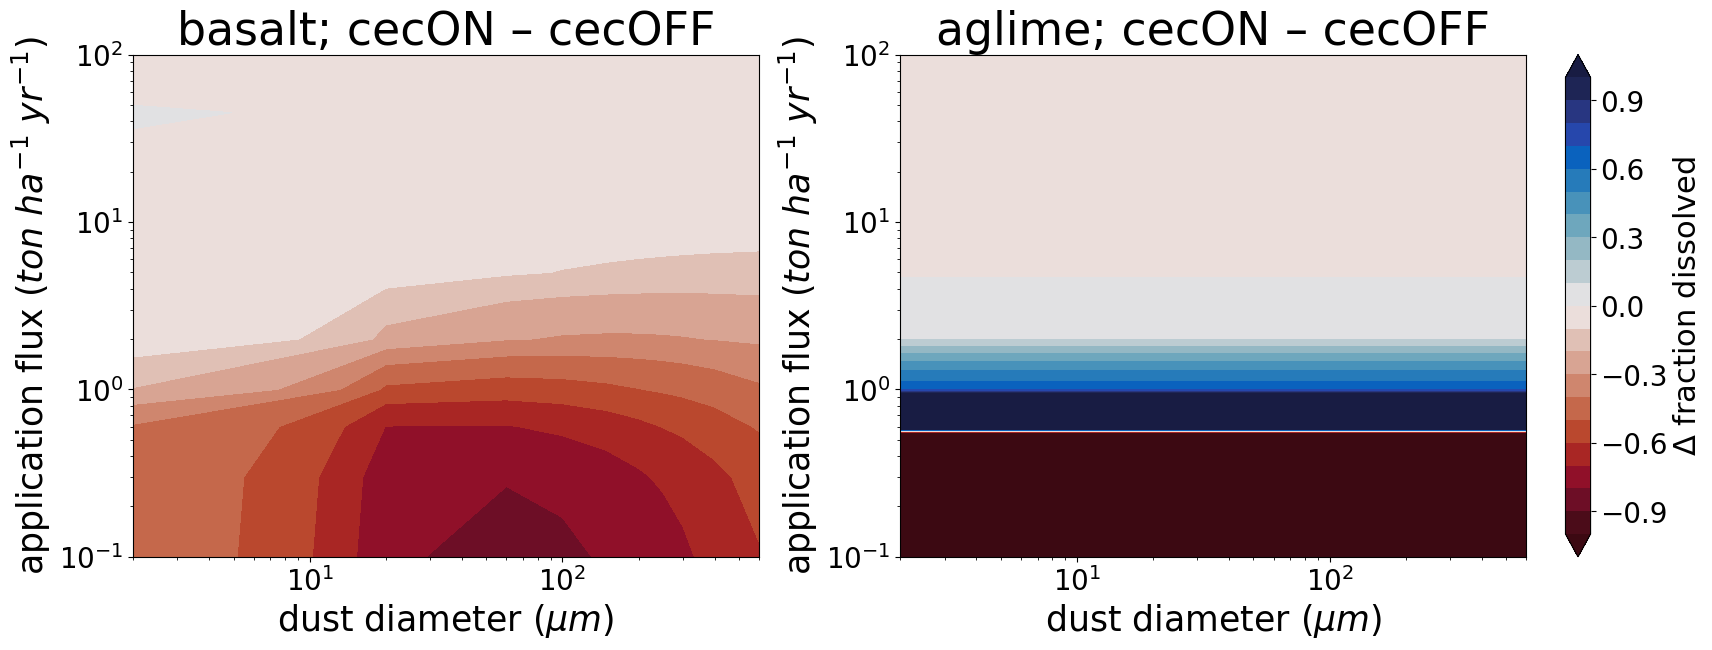

In [11]:
# PLOT difference in fraction dissolved
# --- PLOT --------------------
# set data conditions
pvar = 'fraction_remaining_dissolved' # 'fraction_total_dissolved'
fertlevel_show = 12   # [1 | 2 | 12]
logX = True
logY = True

# pull out the data we want
dssil1_p3 = dssil1[pvar]
dssil2_p3 = dssil2[pvar]
dscc1_p3 = dscc1[pvar]
dscc2_p3 = dscc2[pvar]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dssil1_p3 = dssil1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p3 = dssil2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p3 = dscc1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p3 = dscc2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
include_titles = True
# color palette
col = cmo.balance_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -1, 1
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60
# *****************************

# x and y arrays
# [fertlevel 1, sil]
x1sil = dssil1_p3['dustrad'].values
y1sil = dssil1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 1, cc]
x1cc = dscc1_p3['dustrad'].values
y1cc = dscc1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, sil]
x2sil = dssil2_p3['dustrad'].values
y2sil = dssil2_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, cc]
x2cc = dscc1_p3['dustrad'].values
y2cc = dscc1_p3['dustrate_ton_ha_yr'].values

# update index based on which ferts to show
if fertlevel_show == 1:
    spec_dx1 = 0
    spec_dx2 = 2
else:
    spec_dx1 = spec_dx2 = 0

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=2, hspace=0.3, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

if (fertlevel_show == 2) | (fertlevel_show == 12):
    # --- fertlevel 2 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[0-spec_dx2])
    contour = plt.contourf(x2sil*2,y2sil,dssil2_p3.transpose() - dssil1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    # plt.suptitle("rock dissolution", fontsize=fs_title)
    (plt.title(f"basalt; {cectag_forplotting2} – {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[1-spec_dx2])
    contour = plt.contourf(x2cc*2,y2cc,dscc2_p3.transpose() - dscc1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.title(f"aglime; {cectag_forplotting2} – {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
    cbar = plt.colorbar(contour)
    cbar.set_label(r"$\Delta$ fraction dissolved", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

# if (fertlevel_show == 1) | (fertlevel_show == 12):
#     # --- fertlevel 1 --------------------------------------------------------------------------
#     # --- sil
#     ax = plt.subplot(spec[2-spec_dx1])
#     contour = plt.contourf(x1sil*2,y1sil,dssil1_p3.transpose(), 
#                             levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
#     plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
#     plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
#     # plt.suptitle("rock dissolution", fontsize=fs_title)
#     (plt.title(f"basalt; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
#     plt.tick_params(axis='both', labelsize=fs_tick)
#     (plt.xscale('log') if logX else "")
#     (plt.yscale('log') if logY else "")
#     plt.xlim(xmin, xmax)

#     # --- cc
#     ax = plt.subplot(spec[3-spec_dx1])
#     contour = plt.contourf(x1cc*2,y1cc,dscc1_p3.transpose(), 
#                             levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
#     plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
#     plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
#     plt.tick_params(axis='both', labelsize=fs_tick)
#     (plt.title(f"aglime; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
#     cbar = plt.colorbar(contour)
#     cbar.set_label(r"fraction dissolved", fontsize=fs_cbarlab)
#     cbar.ax.tick_params(labelsize=fs_cbartick)
#     (plt.xscale('log') if logX else "")
#     (plt.yscale('log') if logY else "")
#     plt.xlim(xmin, xmax)

## Plot percent change in fraction dissolved

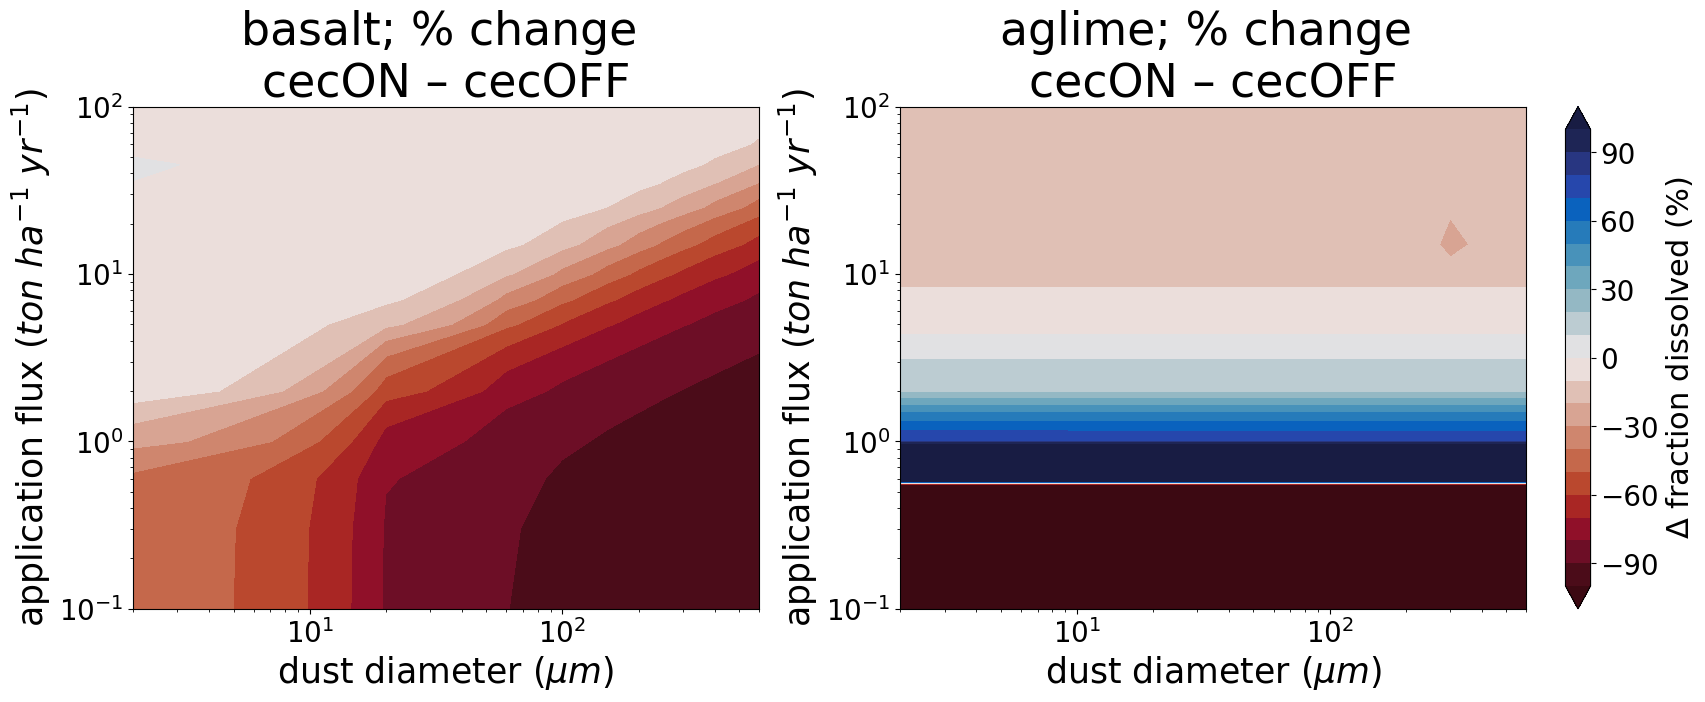

In [12]:
# PLOT difference in fraction dissolved
# --- PLOT --------------------
# set data conditions
pvar = 'fraction_remaining_dissolved' # 'fraction_total_dissolved'
fertlevel_show = 12   # [1 | 2 | 12]
logX = True
logY = True

# pull out the data we want
dssil1_p3 = dssil1[pvar]
dssil2_p3 = dssil2[pvar]
dscc1_p3 = dscc1[pvar]
dscc2_p3 = dscc2[pvar]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dssil1_p3 = dssil1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p3 = dssil2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p3 = dscc1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p3 = dscc2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
include_titles = True
# color palette
col = cmo.balance_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -100, 100
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60
# *****************************

# x and y arrays
# [fertlevel 1, sil]
x1sil = dssil1_p3['dustrad'].values
y1sil = dssil1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 1, cc]
x1cc = dscc1_p3['dustrad'].values
y1cc = dscc1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, sil]
x2sil = dssil2_p3['dustrad'].values
y2sil = dssil2_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, cc]
x2cc = dscc1_p3['dustrad'].values
y2cc = dscc1_p3['dustrate_ton_ha_yr'].values

# update index based on which ferts to show
if fertlevel_show == 1:
    spec_dx1 = 0
    spec_dx2 = 2
else:
    spec_dx1 = spec_dx2 = 0

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=2, hspace=0.3, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

if (fertlevel_show == 2) | (fertlevel_show == 12):
    # --- fertlevel 2 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[0-spec_dx2])
    contour = plt.contourf(x2sil*2,y2sil,((dssil2_p3.transpose() - dssil1_p3.transpose()) / dssil1_p3.transpose()) * 100, 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    # plt.suptitle("rock dissolution", fontsize=fs_title)
    (plt.title(f"basalt; % change \n{cectag_forplotting2} – {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[1-spec_dx2])
    contour = plt.contourf(x2cc*2,y2cc,((dscc2_p3.transpose() - dscc1_p3.transpose()) / dscc1_p3.transpose())*100, 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.title(f"aglime; % change \n{cectag_forplotting2} – {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
    cbar = plt.colorbar(contour)
    cbar.set_label(r"$\Delta$ fraction dissolved (%)", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

# if (fertlevel_show == 1) | (fertlevel_show == 12):
#     # --- fertlevel 1 --------------------------------------------------------------------------
#     # --- sil
#     ax = plt.subplot(spec[2-spec_dx1])
#     contour = plt.contourf(x1sil*2,y1sil,dssil1_p3.transpose(), 
#                             levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
#     plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
#     plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
#     # plt.suptitle("rock dissolution", fontsize=fs_title)
#     (plt.title(f"basalt; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
#     plt.tick_params(axis='both', labelsize=fs_tick)
#     (plt.xscale('log') if logX else "")
#     (plt.yscale('log') if logY else "")
#     plt.xlim(xmin, xmax)

#     # --- cc
#     ax = plt.subplot(spec[3-spec_dx1])
#     contour = plt.contourf(x1cc*2,y1cc,dscc1_p3.transpose(), 
#                             levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
#     plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
#     plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
#     plt.tick_params(axis='both', labelsize=fs_tick)
#     (plt.title(f"aglime; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
#     cbar = plt.colorbar(contour)
#     cbar.set_label(r"fraction dissolved", fontsize=fs_cbarlab)
#     cbar.ax.tick_params(labelsize=fs_cbartick)
#     (plt.xscale('log') if logX else "")
#     (plt.yscale('log') if logY else "")
#     plt.xlim(xmin, xmax)

In [ ]:
# ----

## Plot percent change in alkalinity export 

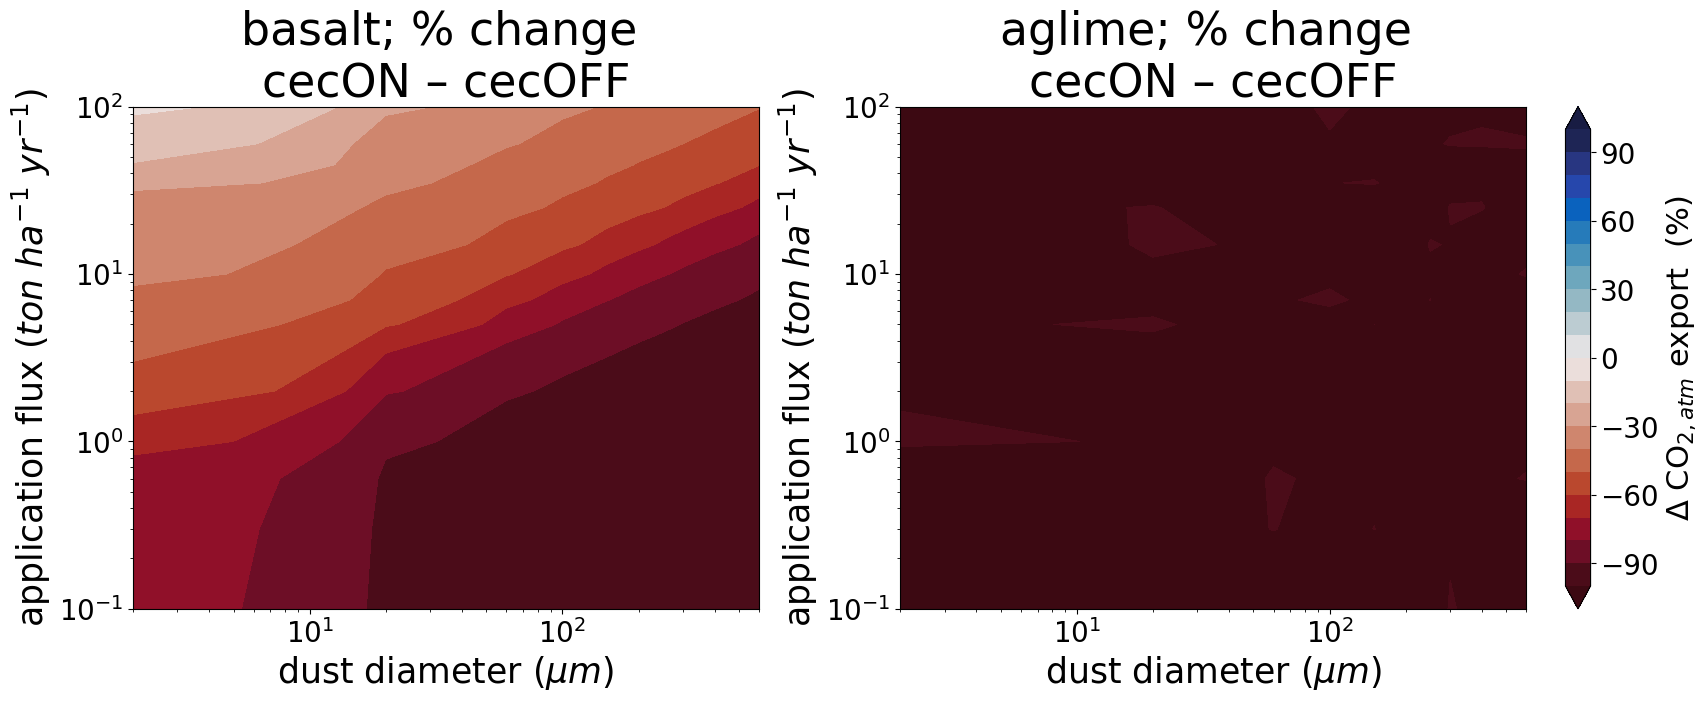

In [13]:
# PLOT difference in carbon export
# --- PLOT --------------------
# set data conditions
pvar = 'co2pot_adv_tonHa_camg' 
loss_perc = 0.0
fertlevel_show = 12   # [1 | 2 | 12]
logX = True
logY = True

# pull out the data we want
dssil1_p3 = dssil1.sel(loss_percent = loss_perc, method='nearest')[pvar]
dscc1_p3 = dscc1.sel(loss_percent = loss_perc, method='nearest')[pvar]
dssil2_p3 = dssil2.sel(loss_percent = loss_perc, method='nearest')[pvar]
dscc2_p3 = dscc2.sel(loss_percent = loss_perc, method='nearest')[pvar]

# # pull out the data we want
# dssil1_p3 = dssil1[pvar]
# dssil2_p3 = dssil2[pvar]
# dscc1_p3 = dscc1[pvar]
# dscc2_p3 = dscc2[pvar]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dssil1_p3 = dssil1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p3 = dssil2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p3 = dscc1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p3 = dscc2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
include_titles = True
# color palette
col = cmo.balance_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -100, 100
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60
# *****************************

# x and y arrays
# [fertlevel 1, sil]
x1sil = dssil1_p3['dustrad'].values
y1sil = dssil1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 1, cc]
x1cc = dscc1_p3['dustrad'].values
y1cc = dscc1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, sil]
x2sil = dssil2_p3['dustrad'].values
y2sil = dssil2_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, cc]
x2cc = dscc1_p3['dustrad'].values
y2cc = dscc1_p3['dustrate_ton_ha_yr'].values

# update index based on which ferts to show
if fertlevel_show == 1:
    spec_dx1 = 0
    spec_dx2 = 2
else:
    spec_dx1 = spec_dx2 = 0

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=2, hspace=0.3, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

if (fertlevel_show == 2) | (fertlevel_show == 12):
    # --- fertlevel 2 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[0-spec_dx2])
    contour = plt.contourf(x2sil*2,y2sil,((dssil2_p3.transpose() - dssil1_p3.transpose()) / dssil1_p3.transpose()) * 100, 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    # plt.suptitle("rock dissolution", fontsize=fs_title)
    (plt.title(f"basalt; % change \n{cectag_forplotting2} – {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[1-spec_dx2])
    contour = plt.contourf(x2cc*2,y2cc,((dscc2_p3.transpose() - dscc1_p3.transpose()) / dscc1_p3.transpose())*100, 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.title(f"aglime; % change \n{cectag_forplotting2} – {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
    cbar = plt.colorbar(contour)
    cbar.set_label(r"$\Delta\ \text{CO}_{2,atm}\ \text{export}$  (%)", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

# if (fertlevel_show == 1) | (fertlevel_show == 12):
#     # --- fertlevel 1 --------------------------------------------------------------------------
#     # --- sil
#     ax = plt.subplot(spec[2-spec_dx1])
#     contour = plt.contourf(x1sil*2,y1sil,dssil1_p3.transpose(), 
#                             levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
#     plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
#     plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
#     # plt.suptitle("rock dissolution", fontsize=fs_title)
#     (plt.title(f"basalt; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
#     plt.tick_params(axis='both', labelsize=fs_tick)
#     (plt.xscale('log') if logX else "")
#     (plt.yscale('log') if logY else "")
#     plt.xlim(xmin, xmax)

#     # --- cc
#     ax = plt.subplot(spec[3-spec_dx1])
#     contour = plt.contourf(x1cc*2,y1cc,dscc1_p3.transpose(), 
#                             levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
#     plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
#     plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
#     plt.tick_params(axis='both', labelsize=fs_tick)
#     (plt.title(f"aglime; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
#     cbar = plt.colorbar(contour)
#     cbar.set_label(r"fraction dissolved", fontsize=fs_cbarlab)
#     cbar.ax.tick_params(labelsize=fs_cbartick)
#     (plt.xscale('log') if logX else "")
#     (plt.yscale('log') if logY else "")
#     plt.xlim(xmin, xmax)

In [29]:
# ----

## Plot the percent change in co2pot storage 
This calculation excludes CO2 from carbonate rock (isolating just atmospheric CO2). 

We get this in a kind of roundabout way, subtracting co2pot_adv_* from co2pot_tot_* because the difference is just the storage term. 

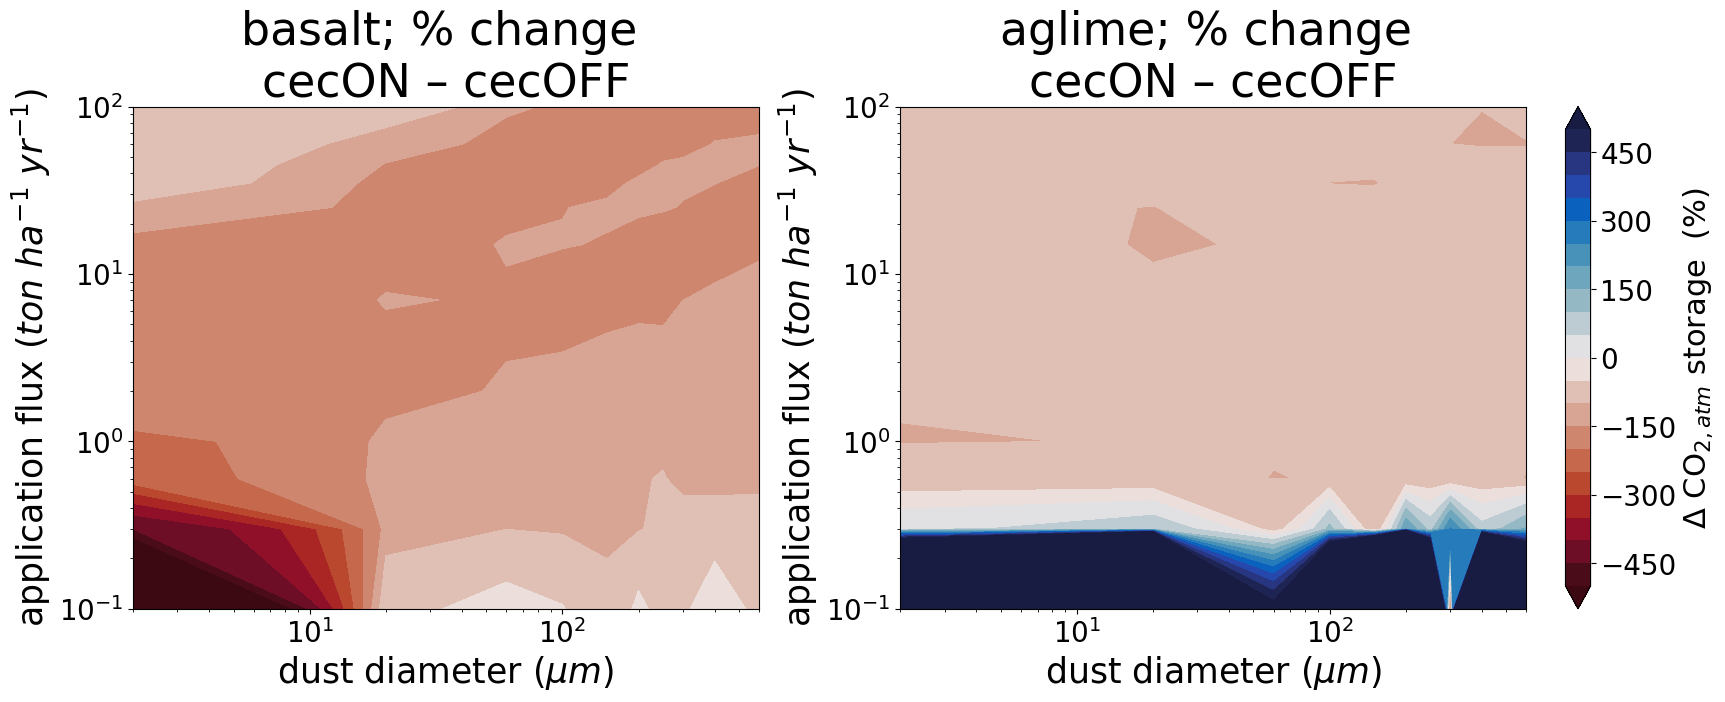

In [14]:
# PLOT difference in carbon export
# --- PLOT --------------------
# set data conditions
pvar1 = 'co2pot_tot_tonHa_camg' 
pvar2 = 'co2pot_adv_tonHa_camg' 
loss_perc = 0.0
fertlevel_show = 12   # [1 | 2 | 12]
logX = True
logY = True

# pull out the data we want
dssil1_p1 = dssil1.sel(loss_percent = loss_perc, method='nearest')[pvar1]
dscc1_p1 = dscc1.sel(loss_percent = loss_perc, method='nearest')[pvar1]
dssil2_p1 = dssil2.sel(loss_percent = loss_perc, method='nearest')[pvar1]
dscc2_p1 = dscc2.sel(loss_percent = loss_perc, method='nearest')[pvar1]

dssil1_p2 = dssil1.sel(loss_percent = loss_perc, method='nearest')[pvar2]
dscc1_p2 = dscc1.sel(loss_percent = loss_perc, method='nearest')[pvar2]
dssil2_p2 = dssil2.sel(loss_percent = loss_perc, method='nearest')[pvar2]
dscc2_p2 = dscc2.sel(loss_percent = loss_perc, method='nearest')[pvar2]

# take the difference
dssil1_p3 = dssil1_p1 - dssil1_p2
dscc1_p3 = dscc1_p1 - dscc1_p2
dssil2_p3 = dssil2_p1 - dssil2_p2
dscc2_p3 = dscc2_p1 - dscc2_p2 

# # pull out the data we want
# dssil1_p3 = dssil1[pvar]
# dssil2_p3 = dssil2[pvar]
# dscc1_p3 = dscc1[pvar]
# dscc2_p3 = dscc2[pvar]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dssil1_p3 = dssil1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p3 = dssil2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p3 = dscc1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p3 = dscc2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
include_titles = True
# color palette
col = cmo.balance_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -500, 500
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60
# *****************************

# x and y arrays
# [fertlevel 1, sil]
x1sil = dssil1_p3['dustrad'].values
y1sil = dssil1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 1, cc]
x1cc = dscc1_p3['dustrad'].values
y1cc = dscc1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, sil]
x2sil = dssil2_p3['dustrad'].values
y2sil = dssil2_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, cc]
x2cc = dscc1_p3['dustrad'].values
y2cc = dscc1_p3['dustrate_ton_ha_yr'].values

# update index based on which ferts to show
if fertlevel_show == 1:
    spec_dx1 = 0
    spec_dx2 = 2
else:
    spec_dx1 = spec_dx2 = 0

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=2, hspace=0.3, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

if (fertlevel_show == 2) | (fertlevel_show == 12):
    # --- fertlevel 2 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[0-spec_dx2])
    contour = plt.contourf(x2sil*2,y2sil,((dssil2_p3.transpose() - dssil1_p3.transpose()) / dssil1_p3.transpose()) * 100, 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    # plt.suptitle("rock dissolution", fontsize=fs_title)
    (plt.title(f"basalt; % change \n{cectag_forplotting2} – {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[1-spec_dx2])
    contour = plt.contourf(x2cc*2,y2cc,((dscc2_p3.transpose() - dscc1_p3.transpose()) / dscc1_p3.transpose())*100, 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.title(f"aglime; % change \n{cectag_forplotting2} – {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
    cbar = plt.colorbar(contour)
    cbar.set_label(r"$\Delta\ \text{CO}_{2,atm}\ \text{storage}$  (%)", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

# if (fertlevel_show == 1) | (fertlevel_show == 12):
#     # --- fertlevel 1 --------------------------------------------------------------------------
#     # --- sil
#     ax = plt.subplot(spec[2-spec_dx1])
#     contour = plt.contourf(x1sil*2,y1sil,dssil1_p3.transpose(), 
#                             levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
#     plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
#     plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
#     # plt.suptitle("rock dissolution", fontsize=fs_title)
#     (plt.title(f"basalt; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
#     plt.tick_params(axis='both', labelsize=fs_tick)
#     (plt.xscale('log') if logX else "")
#     (plt.yscale('log') if logY else "")
#     plt.xlim(xmin, xmax)

#     # --- cc
#     ax = plt.subplot(spec[3-spec_dx1])
#     contour = plt.contourf(x1cc*2,y1cc,dscc1_p3.transpose(), 
#                             levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
#     plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
#     plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
#     plt.tick_params(axis='both', labelsize=fs_tick)
#     (plt.title(f"aglime; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
#     cbar = plt.colorbar(contour)
#     cbar.set_label(r"fraction dissolved", fontsize=fs_cbarlab)
#     cbar.ax.tick_params(labelsize=fs_cbartick)
#     (plt.xscale('log') if logX else "")
#     (plt.yscale('log') if logY else "")
#     plt.xlim(xmin, xmax)

In [ ]:
# ----

## compare net formation of non-carbonate secondary minerals

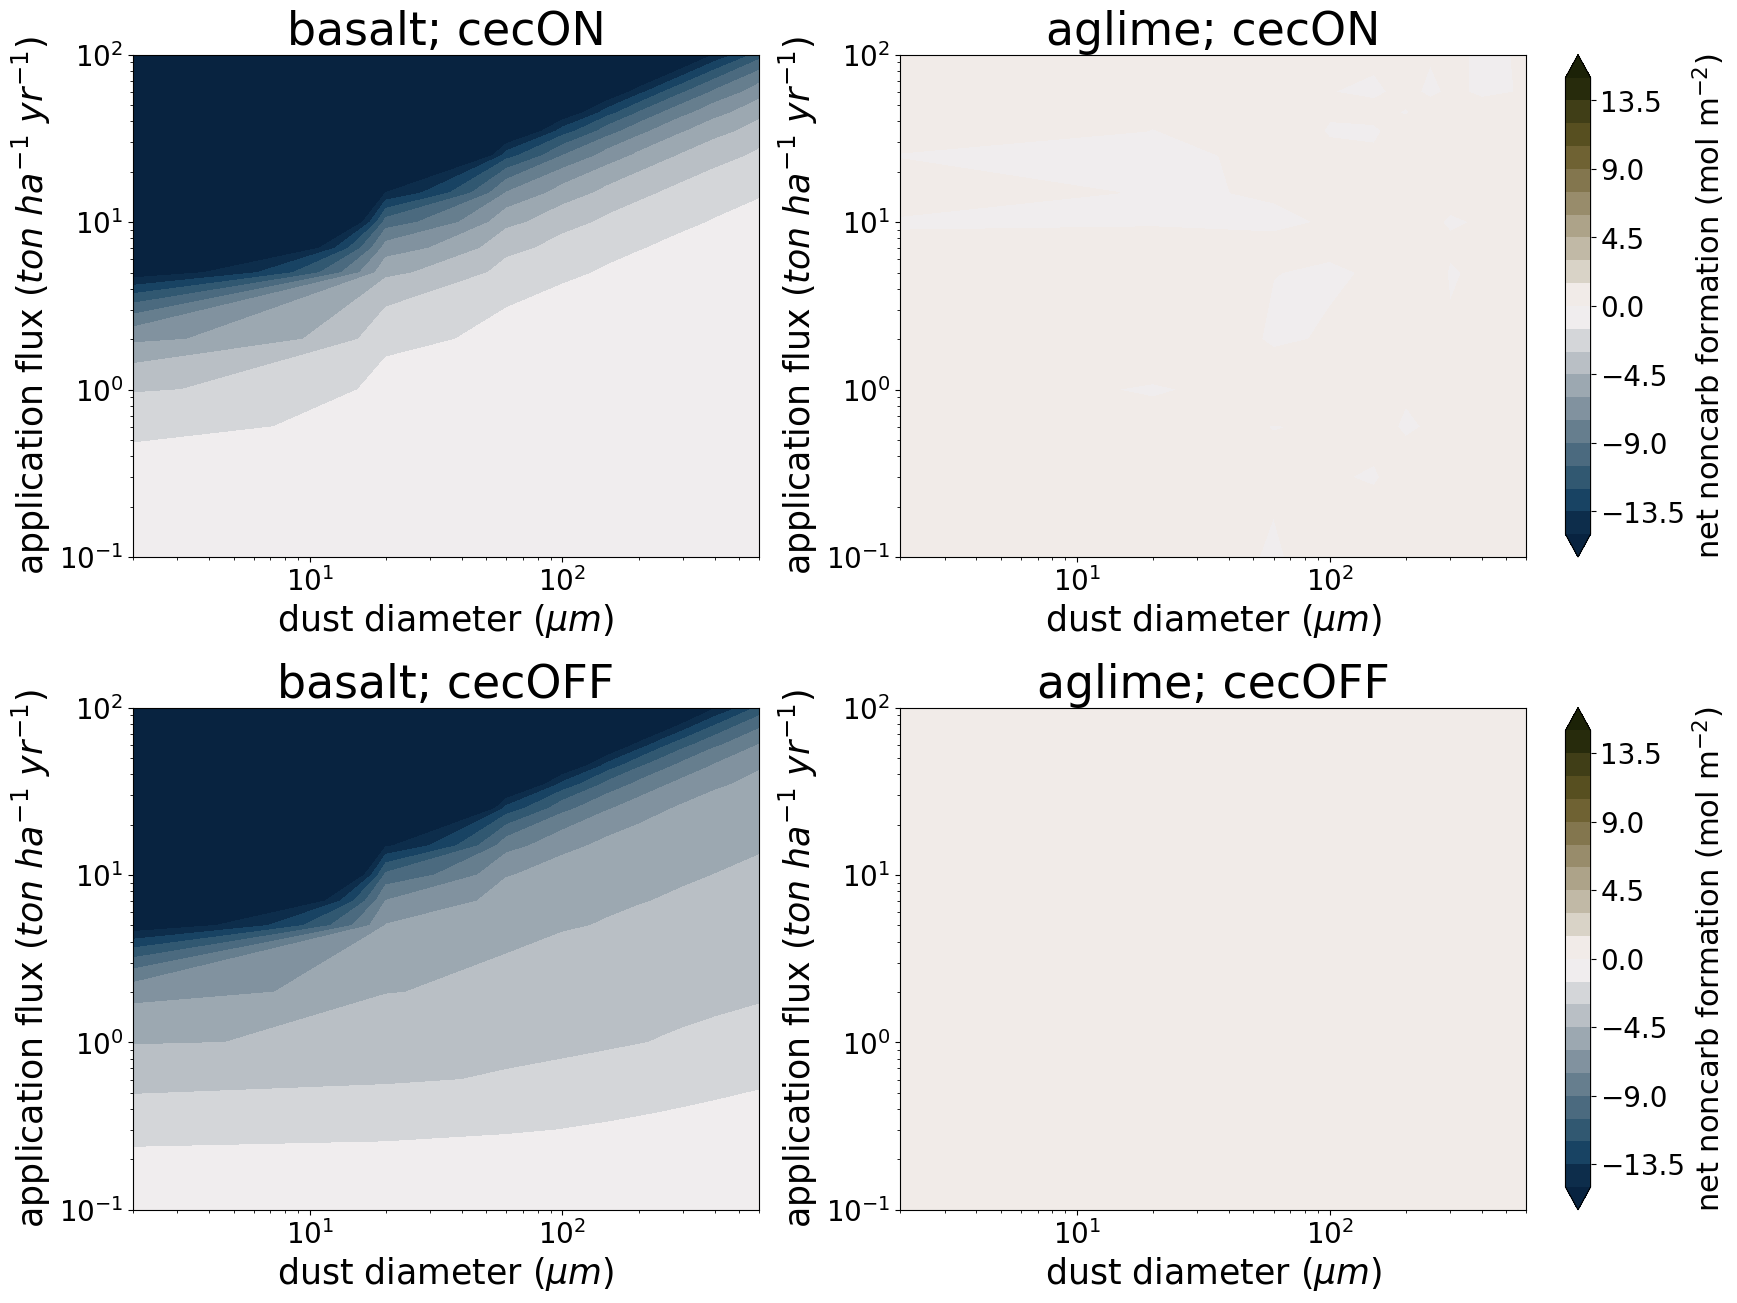

In [15]:
# --- PLOT --------------------
# set data conditions
carb_or_noncarb = 'noncarb'
pvar1, pvar2 = f'{carb_or_noncarb}sld_source_mg', f'{carb_or_noncarb}sld_source_ca'
fertlevel_show = 12   # [1 | 2 | 12]
logX = True
logY = True

# pull out the data we want
dssil1_p3 = dssil1[pvar1] + dssil1[pvar2]
dssil2_p3 = dssil2[pvar1] + dssil2[pvar2]
dscc1_p3 = dscc1[pvar1] + dscc1[pvar2]
dscc2_p3 = dscc2[pvar1] + dscc2[pvar2]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dssil1_p3 = dssil1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p3 = dssil2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p3 = dscc1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p3 = dscc2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
include_titles = True
# color palette
col = cmo.diff
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -15, 15
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60
# *****************************

# x and y arrays
# [fertlevel 1, sil]
x1sil = dssil1_p3['dustrad'].values
y1sil = dssil1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 1, cc]
x1cc = dscc1_p3['dustrad'].values
y1cc = dscc1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, sil]
x2sil = dssil2_p3['dustrad'].values
y2sil = dssil2_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, cc]
x2cc = dscc1_p3['dustrad'].values
y2cc = dscc1_p3['dustrate_ton_ha_yr'].values

# update index based on which ferts to show
if fertlevel_show == 1:
    spec_dx1 = 0
    spec_dx2 = 2
else:
    spec_dx1 = spec_dx2 = 0

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=2, hspace=0.3, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

if (fertlevel_show == 2) | (fertlevel_show == 12):
    # --- fertlevel 2 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[0-spec_dx2])
    contour = plt.contourf(x2sil*2,y2sil,dssil2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    # plt.suptitle("rock dissolution", fontsize=fs_title)
    (plt.title(f"basalt; {cectag_forplotting2}", fontsize=fs_title) if include_titles else "")
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[1-spec_dx2])
    contour = plt.contourf(x2cc*2,y2cc,dscc2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.title(f"aglime; {cectag_forplotting2}", fontsize=fs_title) if include_titles else "")
    cbar = plt.colorbar(contour)
    cbar.set_label(f'net {carb_or_noncarb} formation {r"$(\text{mol}\ \text{m}^{-2})$"}', fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

if (fertlevel_show == 1) | (fertlevel_show == 12):
    # --- fertlevel 1 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[2-spec_dx1])
    contour = plt.contourf(x1sil*2,y1sil,dssil1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    # plt.suptitle("rock dissolution", fontsize=fs_title)
    (plt.title(f"basalt; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[3-spec_dx1])
    contour = plt.contourf(x1cc*2,y1cc,dscc1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.title(f"aglime; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
    cbar = plt.colorbar(contour)
    cbar.set_label(f'net {carb_or_noncarb} formation {r"$(\text{mol}\ \text{m}^{-2})$"}', fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)
    

In [ ]:
# ----

## compare net formation of carbonate minerals

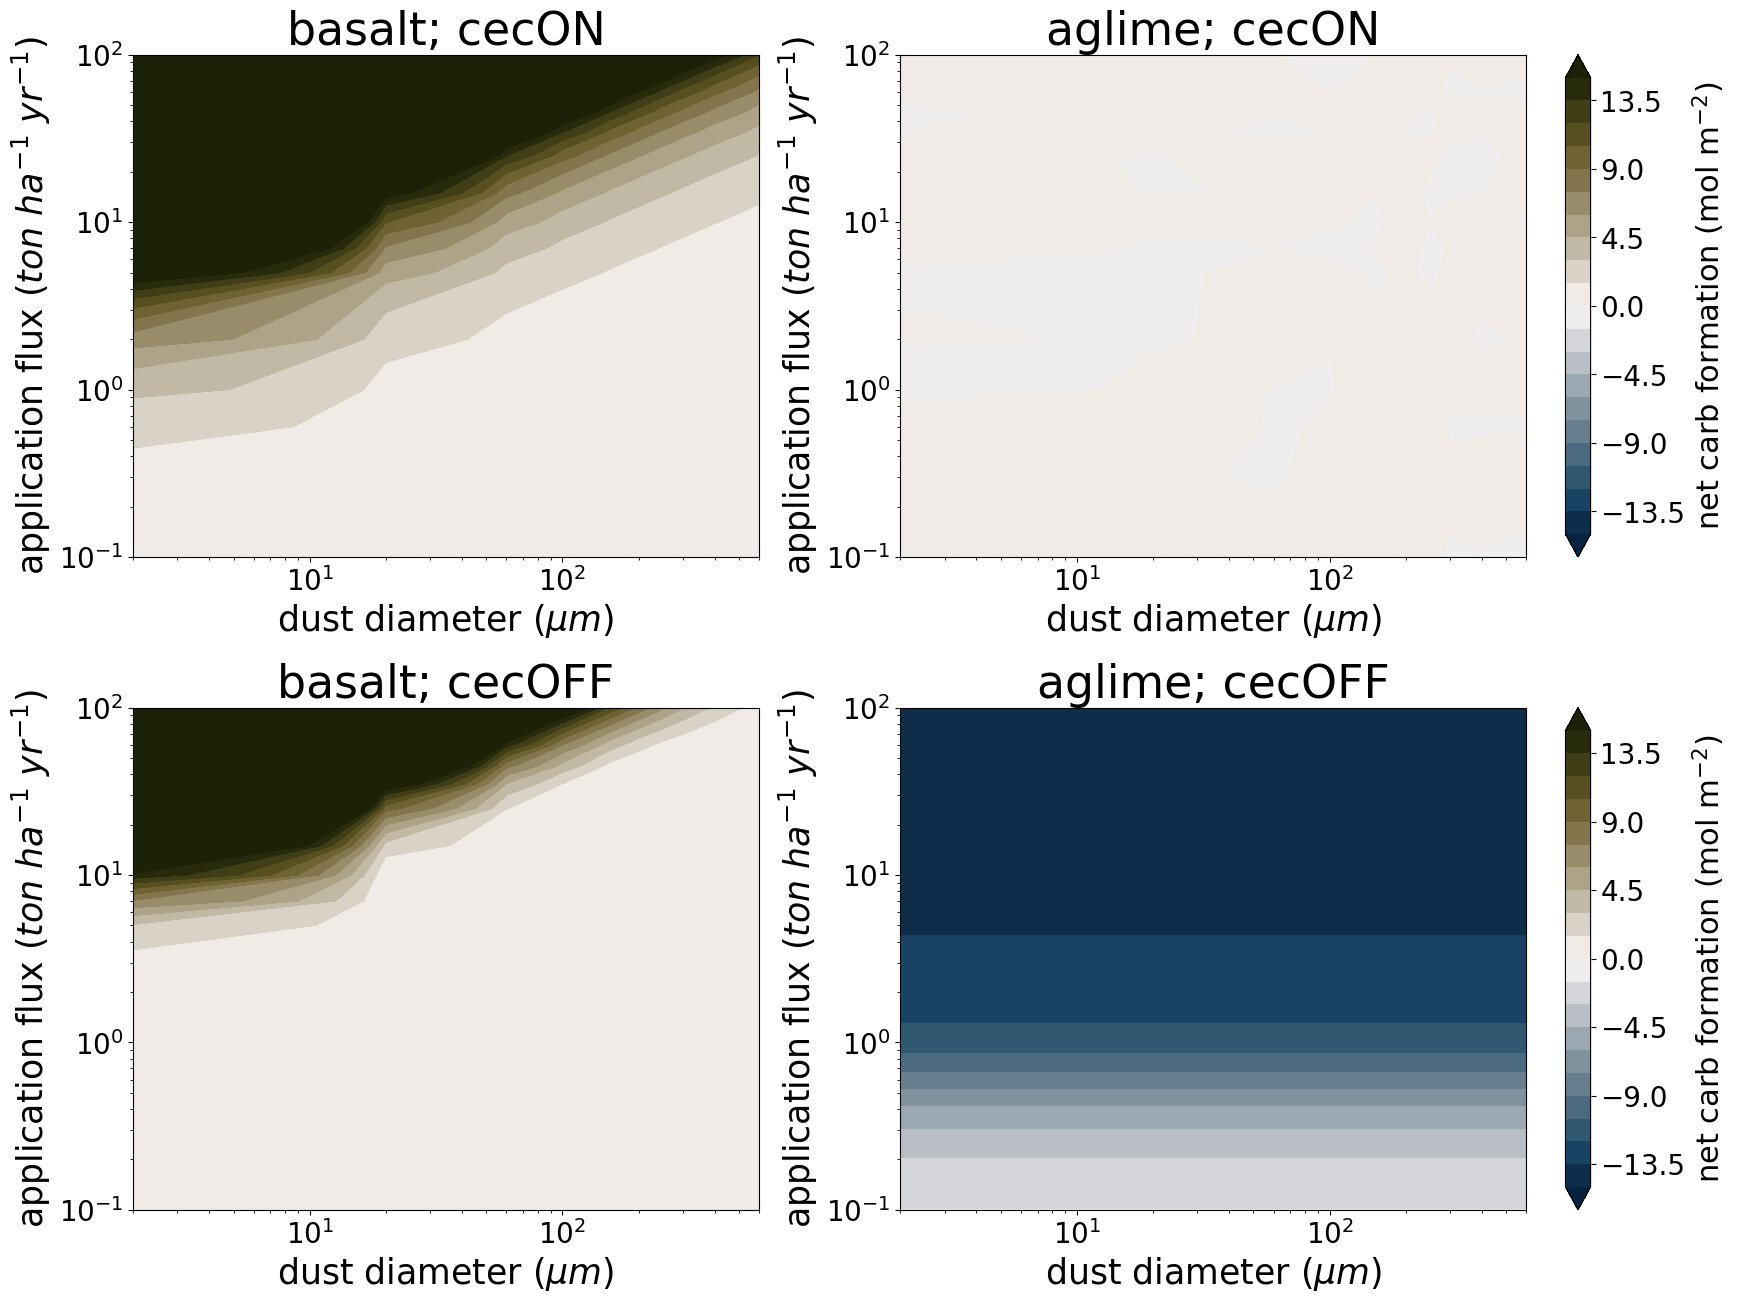

In [16]:
# --- PLOT --------------------
# set data conditions
carb_or_noncarb = 'carb'
pvar1, pvar2 = f'{carb_or_noncarb}sld_source_mg', f'{carb_or_noncarb}sld_source_ca'
fertlevel_show = 12   # [1 | 2 | 12]
logX = True
logY = True

# pull out the data we want
dssil1_p3 = dssil1[pvar1] + dssil1[pvar2]
dssil2_p3 = dssil2[pvar1] + dssil2[pvar2]
dscc1_p3 = dscc1[pvar1] + dscc1[pvar2]
dscc2_p3 = dscc2[pvar1] + dscc2[pvar2]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dssil1_p3 = dssil1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p3 = dssil2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p3 = dscc1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p3 = dscc2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
include_titles = True
# color palette
col = cmo.diff
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -15, 15
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60
# *****************************

# x and y arrays
# [fertlevel 1, sil]
x1sil = dssil1_p3['dustrad'].values
y1sil = dssil1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 1, cc]
x1cc = dscc1_p3['dustrad'].values
y1cc = dscc1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, sil]
x2sil = dssil2_p3['dustrad'].values
y2sil = dssil2_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, cc]
x2cc = dscc1_p3['dustrad'].values
y2cc = dscc1_p3['dustrate_ton_ha_yr'].values

# update index based on which ferts to show
if fertlevel_show == 1:
    spec_dx1 = 0
    spec_dx2 = 2
else:
    spec_dx1 = spec_dx2 = 0

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=2, hspace=0.3, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

if (fertlevel_show == 2) | (fertlevel_show == 12):
    # --- fertlevel 2 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[0-spec_dx2])
    contour = plt.contourf(x2sil*2,y2sil,dssil2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    # plt.suptitle("rock dissolution", fontsize=fs_title)
    (plt.title(f"basalt; {cectag_forplotting2}", fontsize=fs_title) if include_titles else "")
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[1-spec_dx2])
    contour = plt.contourf(x2cc*2,y2cc,dscc2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.title(f"aglime; {cectag_forplotting2}", fontsize=fs_title) if include_titles else "")
    cbar = plt.colorbar(contour)
    cbar.set_label(f'net {carb_or_noncarb} formation {r"$(\text{mol}\ \text{m}^{-2})$"}', fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

if (fertlevel_show == 1) | (fertlevel_show == 12):
    # --- fertlevel 1 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[2-spec_dx1])
    contour = plt.contourf(x1sil*2,y1sil,dssil1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    # plt.suptitle("rock dissolution", fontsize=fs_title)
    (plt.title(f"basalt; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[3-spec_dx1])
    contour = plt.contourf(x1cc*2,y1cc,dscc1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.title(f"aglime; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
    cbar = plt.colorbar(contour)
    cbar.set_label(f'net {carb_or_noncarb} formation {r"$(\text{mol}\ \text{m}^{-2})$"}', fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)
    

In [ ]:
# ----

## Compare the depth profile of base saturation over time 

In [11]:
dssil1_v1

<xarray.Dataset> Size: 14MB
Dimensions:                  (depth: 30, time: 28, dustrate_ton_ha_yr: 15,
                              dustrad: 10)
Coordinates:
  * depth                    (depth) float64 240B 0.008333 0.025 ... 0.4917
  * time                     (time) float64 224B 0.000126 0.000376 ... 15.0
  * dustrate_ton_ha_yr       (dustrate_ton_ha_yr) float64 120B 0.0 0.1 ... 100.0
  * dustrad                  (dustrad) int32 40B 1 10 30 50 ... 125 150 200 300
Data variables: (12/15)
    ca                       (dustrate_ton_ha_yr, dustrad, depth, time) float64 1MB ...
    mg                       (dustrate_ton_ha_yr, dustrad, depth, time) float64 1MB ...
    k                        (dustrate_ton_ha_yr, dustrad, depth, time) float64 1MB ...
    no3                      (dustrate_ton_ha_yr, dustrad, depth, time) float64 1MB ...
    na                       (dustrate_ton_ha_yr, dustrad, depth, time) float64 1MB ...
    h                        (dustrate_ton_ha_yr, dustrad, depth, time) float64 1MB ...
    ...                       ...
    no3_coredep              (dustrate_ton_ha_yr, dustrad, depth, time) float64 1MB ...
    na_coredep               (dustrate_ton_ha_yr, dustrad, depth, time) float64 1MB ...
    h_coredep                (dustrate_ton_ha_yr, dustrad, depth, time) float64 1MB ...
    base_saturation          (dustrate_ton_ha_yr, dustrad, depth, time) float64 1MB ...
    base_saturation_coredep  (dustrate_ton_ha_yr, dustrad, depth, time) float64 1MB ...
    int_dust_ton_ha_yr       (dustrate_ton_ha_yr, dustrad, time) float64 34kB ...
Attributes:
    outfile:  prof_aq(ads%cec)

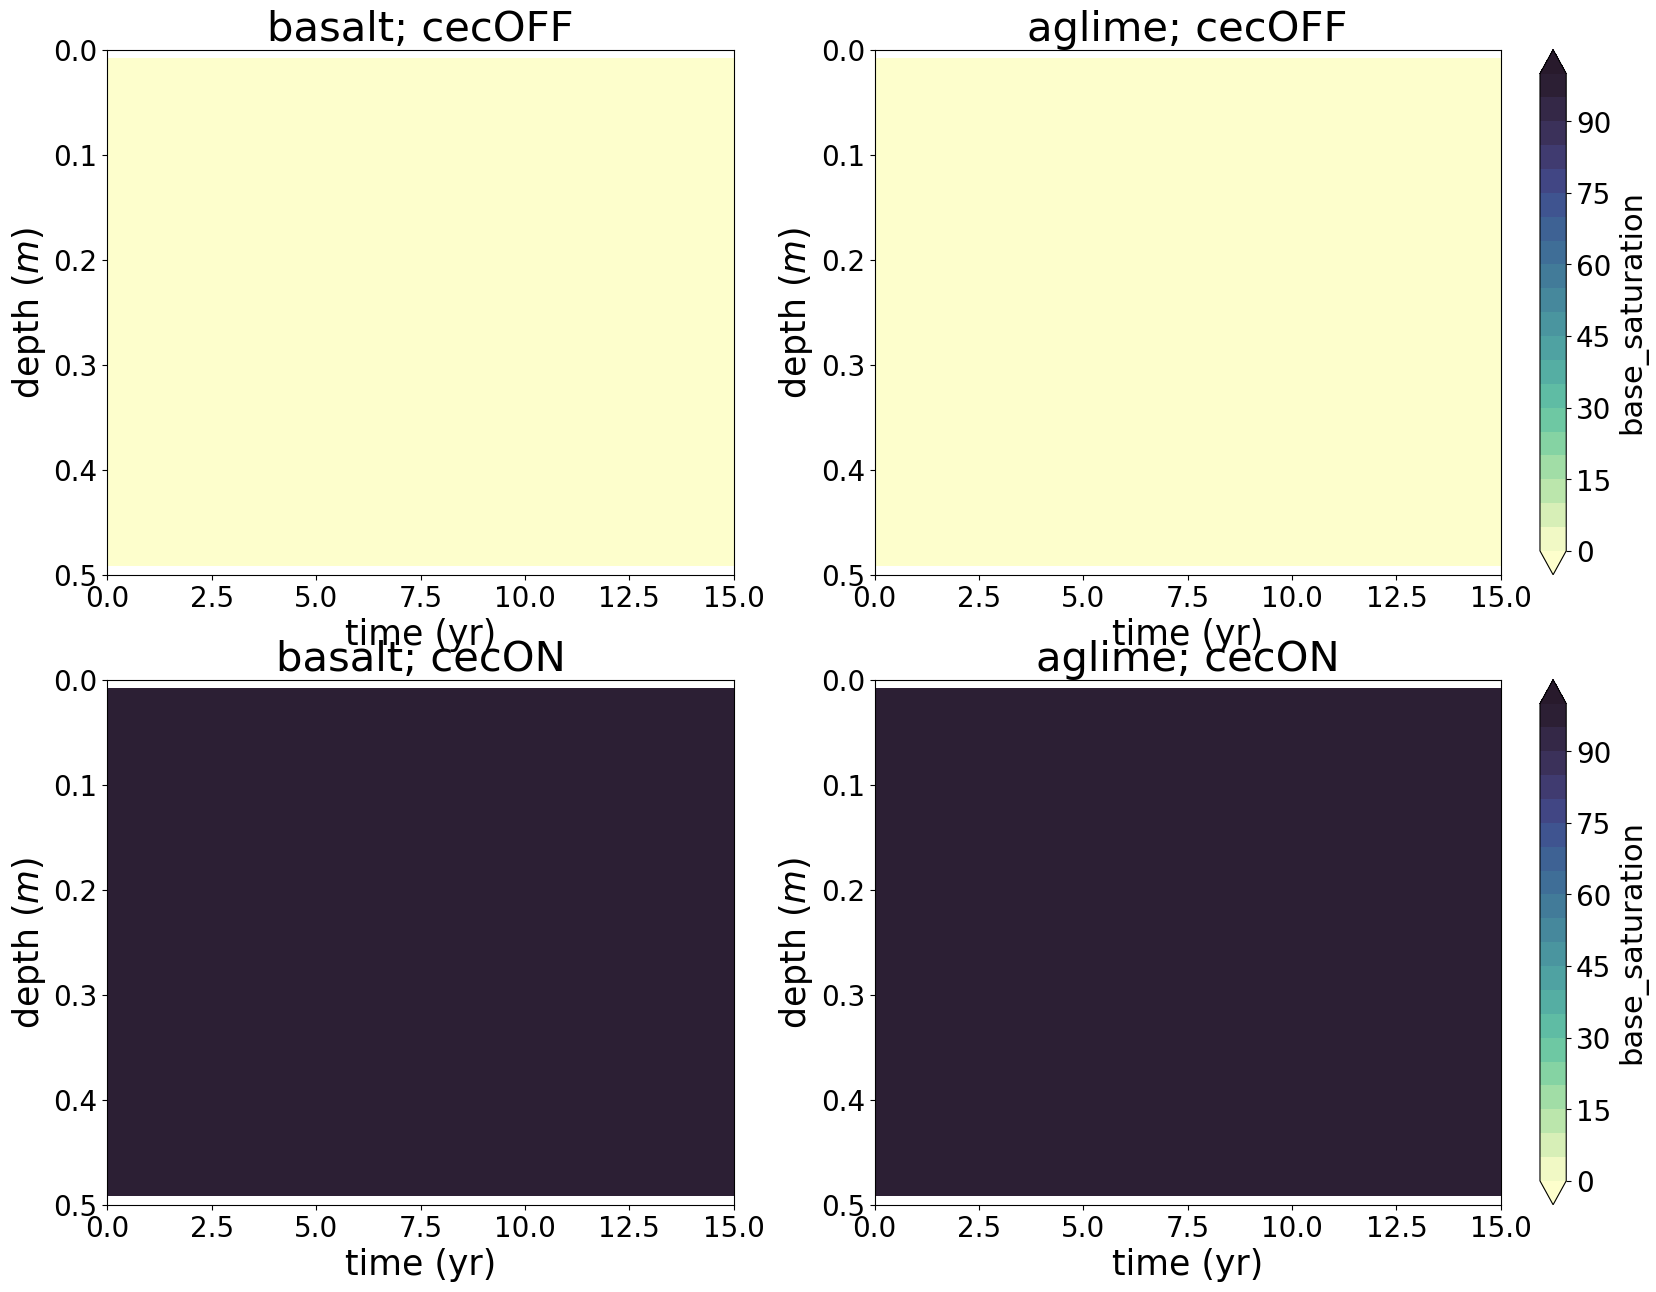

In [17]:
# --- base saturation with depth over time 
# --- PLOT --------------------
# set data conditions
var = "base_saturation"
dustrate = 20
dustrad = 40
logX = False
logY = False
contourline_threshold = 10 

# pull out the data we want 
dsp1 = dssil1_v1.sel(dustrate_ton_ha_yr = dustrate, dustrad = dustrad, method='nearest')[var].copy()    # silicate, cec 1
dsp2 = dscc1_v1.sel(dustrate_ton_ha_yr = dustrate, dustrad = dustrad, method='nearest')[var].copy()     # calcite, cec 1
dsp3 = dssil2_v1.sel(dustrate_ton_ha_yr = dustrate, dustrad = dustrad, method='nearest')[var].copy()    # silicate, cec 2
dsp4 = dscc2_v1.sel(dustrate_ton_ha_yr = dustrate, dustrad = dustrad, method='nearest')[var].copy()     # calcite, cec 2

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsp1 = dsp1.interpolate_na(dim='time', method='linear').copy()
dsp2 = dsp2.interpolate_na(dim='time', method='linear').copy()
dsp3 = dsp3.interpolate_na(dim='time', method='linear').copy()
dsp4 = dsp4.interpolate_na(dim='time', method='linear').copy()

# *****************************
# --- plot aesthetics
include_titles = True
# color palette
col = cmo.deep
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = 0,100
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 15
ymin, ymax = 0.5, 0
# *****************************

# x and y arrays
# [case1]
x1 = dsp1['time'].values
y1 = dsp1['depth'].values
# [case2]
x2 = dsp2['time'].values
y2 = dsp2['depth'].values
# [case3]
x3 = dsp3['time'].values
y3 = dsp3['depth'].values
# [case4]
x4 = dsp4['time'].values
y4 = dsp4['depth'].values


# normalize color scale to center at zero
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=contourline_threshold)
# norm = mcolors.LogNorm(vmin=dsp1.min(), vmax=dsp1.max())
norm = None

# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[0.8, 1.0])
plt.figure(figsize=(20,15))

# --- high alpha
ax = plt.subplot(spec[0])
contour = plt.contourf(x1,y1, dsp1, 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1,y1,dsp1,levels=[contourline_threshold], colors='black', linewidths=2)
plt.xlabel(r"time (yr)", fontsize=fs_xlab)
plt.ylabel(r"depth $(m)$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
(plt.title(f"basalt; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- mid alpha
ax = plt.subplot(spec[1])
contour = plt.contourf(x2,y2, dsp2, 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x2,y2, dsp2,levels=[contourline_threshold], colors='black', linewidths=2)
plt.xlabel(r"time (yr)", fontsize=fs_xlab)
plt.ylabel(r"depth $(m)$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
(plt.title(f"aglime; {cectag_forplotting1}", fontsize=fs_title) if include_titles else "")
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(f"{var}", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)

# --- low alpha
ax = plt.subplot(spec[2])
contour = plt.contourf(x3,y3, dsp3, 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x3,y3, dsp3,levels=[contourline_threshold], colors='black', linewidths=2)
plt.xlabel(r"time (yr)", fontsize=fs_xlab)
plt.ylabel(r"depth $(m)$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
(plt.title(f"basalt; {cectag_forplotting2}", fontsize=fs_title) if include_titles else "")
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- low alpha
ax = plt.subplot(spec[3])
contour = plt.contourf(x4,y4, dsp4, 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x4,y4, dsp4,levels=[contourline_threshold], colors='black', linewidths=2)
plt.xlabel(r"time (yr)", fontsize=fs_xlab)
plt.ylabel(r"depth $(m)$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
(plt.title(f"aglime; {cectag_forplotting2}", fontsize=fs_title) if include_titles else "")
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(f"{var}", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)



In [ ]:
# ----

# Read in co2 data from a selected run to get timeseries fluxes

In [35]:
# --- read in data
this_fs1 = "gbas"
this_fs2 = "cc"

apprate = "1000p0"
dustrad = "200"

cecoff = "basev1"
cecon = "basev3a"
tauoff = 15
tauon = 15

cecON_dirname1 = f'hiFert_{this_fs1}_{cecon}_site_311a_app_{apprate}_psize_{dustrad}_{this_fs1}_field_tau{tauon}p0'
cecOFF_dirname1 = f'hiFert_{this_fs1}_{cecoff}_site_311a_app_{apprate}_psize_{dustrad}_{this_fs1}_field_tau{tauoff}p0'

cecON_dirname2 = f'hiFert_{this_fs2}_{cecon}_site_311a_app_{apprate}_psize_{dustrad}_{this_fs2}_field_tau{tauon}p0'
cecOFF_dirname2 = f'hiFert_{this_fs2}_{cecoff}_site_311a_app_{apprate}_psize_{dustrad}_{this_fs2}_field_tau{tauoff}p0'

outdir = "s3://carbonplan-carbon-removal/SCEPTER/scepter_output_scratch/"
subdir = "postproc_flxs"
fn = "co2_flxs.pkl"

df_on1 = pd.read_pickle(os.path.join(outdir, cecON_dirname1, subdir, fn))
df_off1 = pd.read_pickle(os.path.join(outdir, cecOFF_dirname1, subdir, fn))

df_on2 = pd.read_pickle(os.path.join(outdir, cecON_dirname2, subdir, fn))
df_off2 = pd.read_pickle(os.path.join(outdir, cecOFF_dirname2, subdir, fn))

In [36]:
# --- read in control
this_fs1 = "gbas"
this_fs2 = "cc"

apprate = "0p0"
dustrad = "1"

cecON_dirname1ctrl = f'hiFert_{this_fs1}_{cecon}_site_311a_app_{apprate}_psize_{dustrad}_{this_fs1}_field_tau{tauon}p0'
cecOFF_dirname1ctrl = f'hiFert_{this_fs1}_{cecoff}_site_311a_app_{apprate}_psize_{dustrad}_{this_fs1}_field_tau{tauoff}p0'

cecON_dirname2ctrl = f'hiFert_{this_fs2}_{cecon}_site_311a_app_{apprate}_psize_{dustrad}_{this_fs2}_field_tau{tauon}p0'
cecOFF_dirname2ctrl = f'hiFert_{this_fs2}_{cecoff}_site_311a_app_{apprate}_psize_{dustrad}_{this_fs2}_field_tau{tauoff}p0'

outdir = "s3://carbonplan-carbon-removal/SCEPTER/scepter_output_scratch/"
subdir = "postproc_flxs"
fn = "co2_flxs.pkl"

df_on1ctrl = pd.read_pickle(os.path.join(outdir, cecON_dirname1ctrl, subdir, fn))
df_off1ctrl = pd.read_pickle(os.path.join(outdir, cecOFF_dirname1ctrl, subdir, fn))

df_on2ctrl = pd.read_pickle(os.path.join(outdir, cecON_dirname2ctrl, subdir, fn))
df_off2ctrl = pd.read_pickle(os.path.join(outdir, cecOFF_dirname2ctrl, subdir, fn))

In [37]:
# --- SUBTRACT CONTROL? 
subtract_ctrl = True

if subtract_ctrl:
    # identify numeric cols
    numeric_cols = df_on1.select_dtypes(include="number").columns.difference(["time"])
    timecol_on = df_on1[['time']].copy()
    timecol_off = df_off1[['time']].copy()
    flxtypecol = df_on1[['flx_type']].copy()
    # [fs 1]
    df_on1 = df_on1[numeric_cols].subtract(df_on1ctrl[numeric_cols]).copy()
    df_on1['time'] = timecol_on.copy()
    df_on1['flx_type'] = flxtypecol.copy()

    df_off1 = df_off1[numeric_cols].subtract(df_off1ctrl[numeric_cols]).copy()
    df_off1['time'] = timecol_off.copy()
    df_off1['flx_type'] = flxtypecol.copy()
    # [fs 2]
    df_on2 = df_on2[numeric_cols].subtract(df_on2ctrl[numeric_cols]).copy()
    df_on2['time'] = timecol_on.copy()
    df_on2['flx_type'] = flxtypecol.copy()

    df_off2 = df_off2[numeric_cols].subtract(df_off2ctrl[numeric_cols]).copy()
    df_off2['time'] = timecol_off.copy()
    df_off2['flx_type'] = flxtypecol.copy()

In [38]:
# --- confirm mass balance
#     [ GOOD ENOUGH ! ]
# we should have: [adv + tflx + sources + dif = 0]
df_off1 = df_off1.assign(mass_balance_check = df_off1['co2flx_adv'] + df_off1['co2flx_tflx'] + df_off1['co2flx_dif'] + df_off1['co2flx_resp'] + df_off1['co2flx_inorg'])
df_on1 = df_on1.assign(mass_balance_check = df_on1['co2flx_adv'] + df_on1['co2flx_tflx'] + df_on1['co2flx_dif'] + df_on1['co2flx_resp'] + df_on1['co2flx_inorg'])
df_off2 = df_off2.assign(mass_balance_check = df_off2['co2flx_adv'] + df_off2['co2flx_tflx'] + df_off2['co2flx_dif'] + df_off2['co2flx_resp'] + df_off2['co2flx_inorg'])
df_on2 = df_on2.assign(mass_balance_check = df_on2['co2flx_adv'] + df_on2['co2flx_tflx'] + df_on2['co2flx_dif'] + df_on2['co2flx_resp'] + df_on2['co2flx_inorg'])

# separate integrated and regular fluxes
# [ basalt ]
df_off_int1 = df_off1[df_off1['flx_type'] == "int_flx"]
df_on_int1 = df_on1[df_on1['flx_type'] == "int_flx"]
df_off_flx1 = df_off1[df_off1['flx_type'] == "flx"]
df_on_flx1 = df_on1[df_on1['flx_type'] == "flx"]

df_off_int2 = df_off2[df_off2['flx_type'] == "int_flx"]
df_on_int2 = df_on2[df_on2['flx_type'] == "int_flx"]
df_off_flx2 = df_off2[df_off2['flx_type'] == "flx"]
df_on_flx2 = df_on2[df_on2['flx_type'] == "flx"]


# plt.plot(df_on_int['time'], df_on_int['mass_balance_check'], label='cec on')
# plt.plot(df_off_int['time'], df_off_int['mass_balance_check'], label='cec off')
# plt.legend()

In [39]:
df_on_flx2.columns

Index(['cc', 'co2flx_adv', 'co2flx_adv_noinorg', 'co2flx_dif', 'co2flx_inorg',
       'co2flx_resp', 'co2flx_tflx', 'g2', 'time', 'flx_type',
       'mass_balance_check'],
      dtype='object')

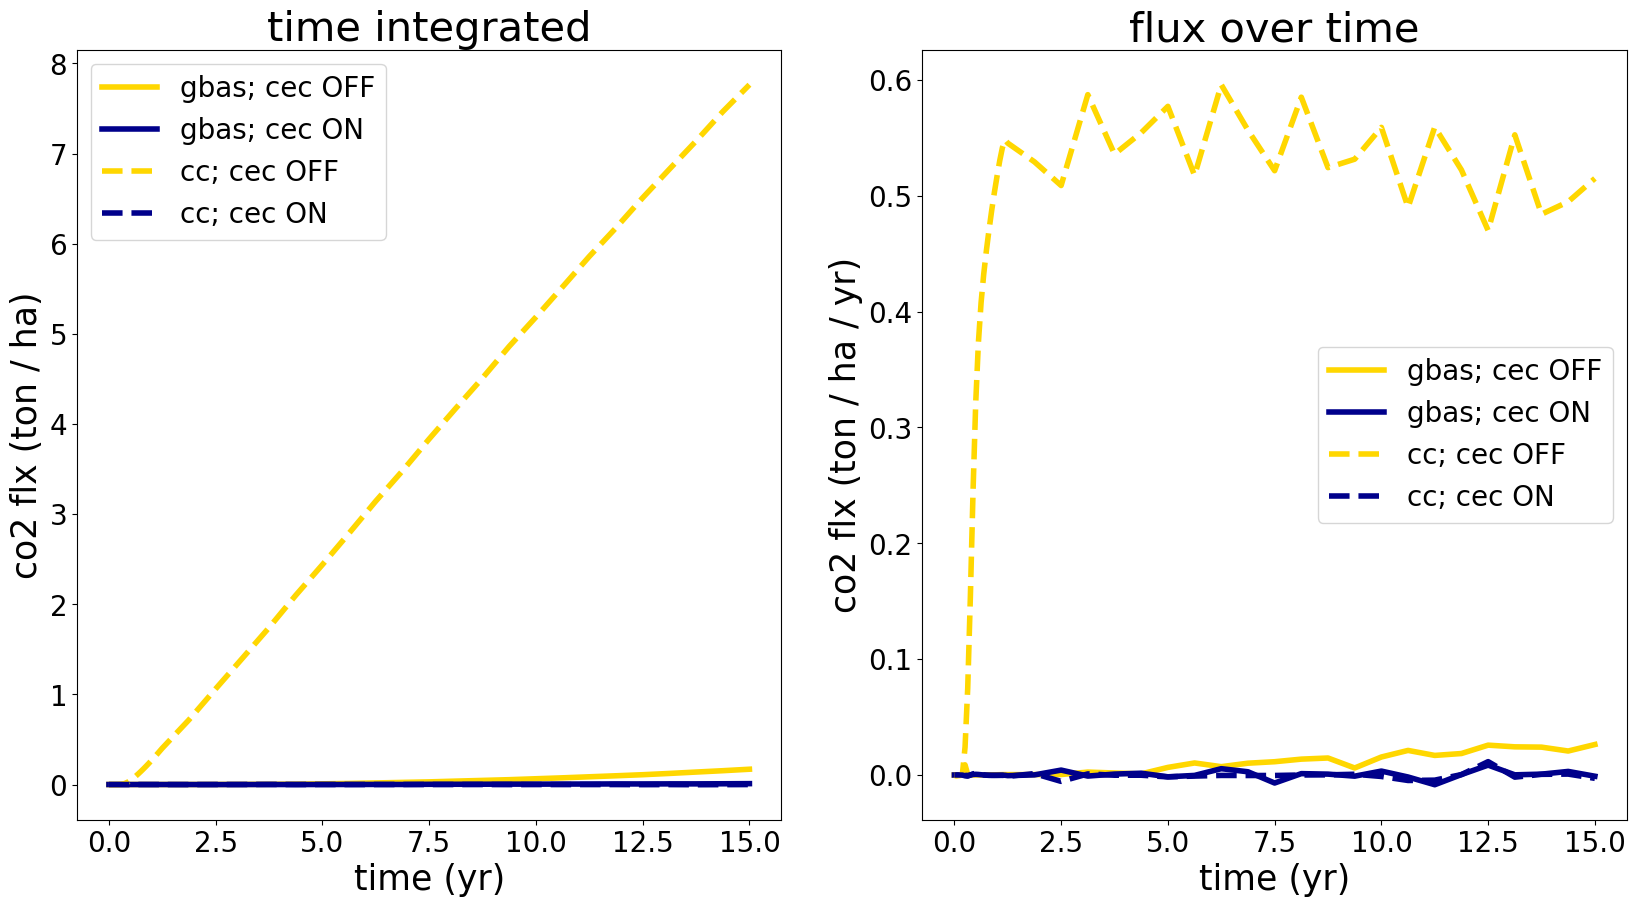

In [40]:
# --- CDR individual fluxes
pvar = "co2flx_adv"
# 
# [ ADV: higher values = more CDR (positive = flux out of soil column) ]
# [ DIF: lower values = more CDR (positive = flux out of soil to atm) ]
#
# *****************************
# --- plot aesthetics
include_titles = True
lwds = 4  # linewidths
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
# color limits
cmin, cmax = 0,100
cbar_extend = "both"    # both, max, or min
# axis limits
# xmin, xmax = (2 if logX else 0), 15
# ymin, ymax = 0.5, 0
# *****************************

# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=1, hspace=0.2, width_ratios=[1.0, 1.0])
plt.figure(figsize=(20,10))

# integrated flux
ax = plt.subplot(spec[0])
# [ BASALT ]
plt.plot(df_off_int1['time'], df_off_int1[pvar], 
        label = f'{this_fs1}; cec OFF', linewidth=lwds, c='gold')
plt.plot(df_on_int1['time'], df_on_int1[pvar], 
        label = f'{this_fs1}; cec ON', linewidth=lwds, c='darkblue')
# [ AGLIME ]
plt.plot(df_off_int2['time'], df_off_int2[pvar], 
        label = f'{this_fs2}; cec OFF', linewidth=lwds, linestyle='--', c='gold')
plt.plot(df_on_int2['time'], df_on_int2[pvar], 
        label = f'{this_fs2}; cec ON', linewidth=lwds, linestyle='--', c='darkblue')
plt.xlabel("time (yr)", fontsize = fs_xlab)
plt.ylabel("co2 flx (ton / ha)", fontsize = fs_xlab)
(plt.title("time integrated", fontsize=fs_title) if include_titles else "")
plt.tick_params(axis='both', labelsize=fs_tick)
plt.legend(fontsize=fs_tick)

# flux
ax = plt.subplot(spec[1])
# [ BASALT ]
plt.plot(df_off_flx1['time'], df_off_flx1[pvar], 
        label = f'{this_fs1}; cec OFF', linewidth=lwds, c='gold')
plt.plot(df_on_flx1['time'], df_on_flx1[pvar], 
        label = f'{this_fs1}; cec ON', linewidth=lwds, c='darkblue')
# [ AGLIME ]
plt.plot(df_off_flx2['time'], df_off_flx2[pvar], 
        label = f'{this_fs2}; cec OFF', linewidth=lwds, linestyle='--', c='gold')
plt.plot(df_on_flx2['time'], df_on_flx2[pvar], 
        label = f'{this_fs2}; cec ON', linewidth=lwds, linestyle='--', c='darkblue')
plt.xlabel("time (yr)", fontsize = fs_xlab)
plt.ylabel("co2 flx (ton / ha / yr)", fontsize = fs_xlab)
(plt.title("flux over time", fontsize=fs_title) if include_titles else "")
plt.tick_params(axis='both', labelsize=fs_tick)
plt.legend(fontsize=fs_tick)


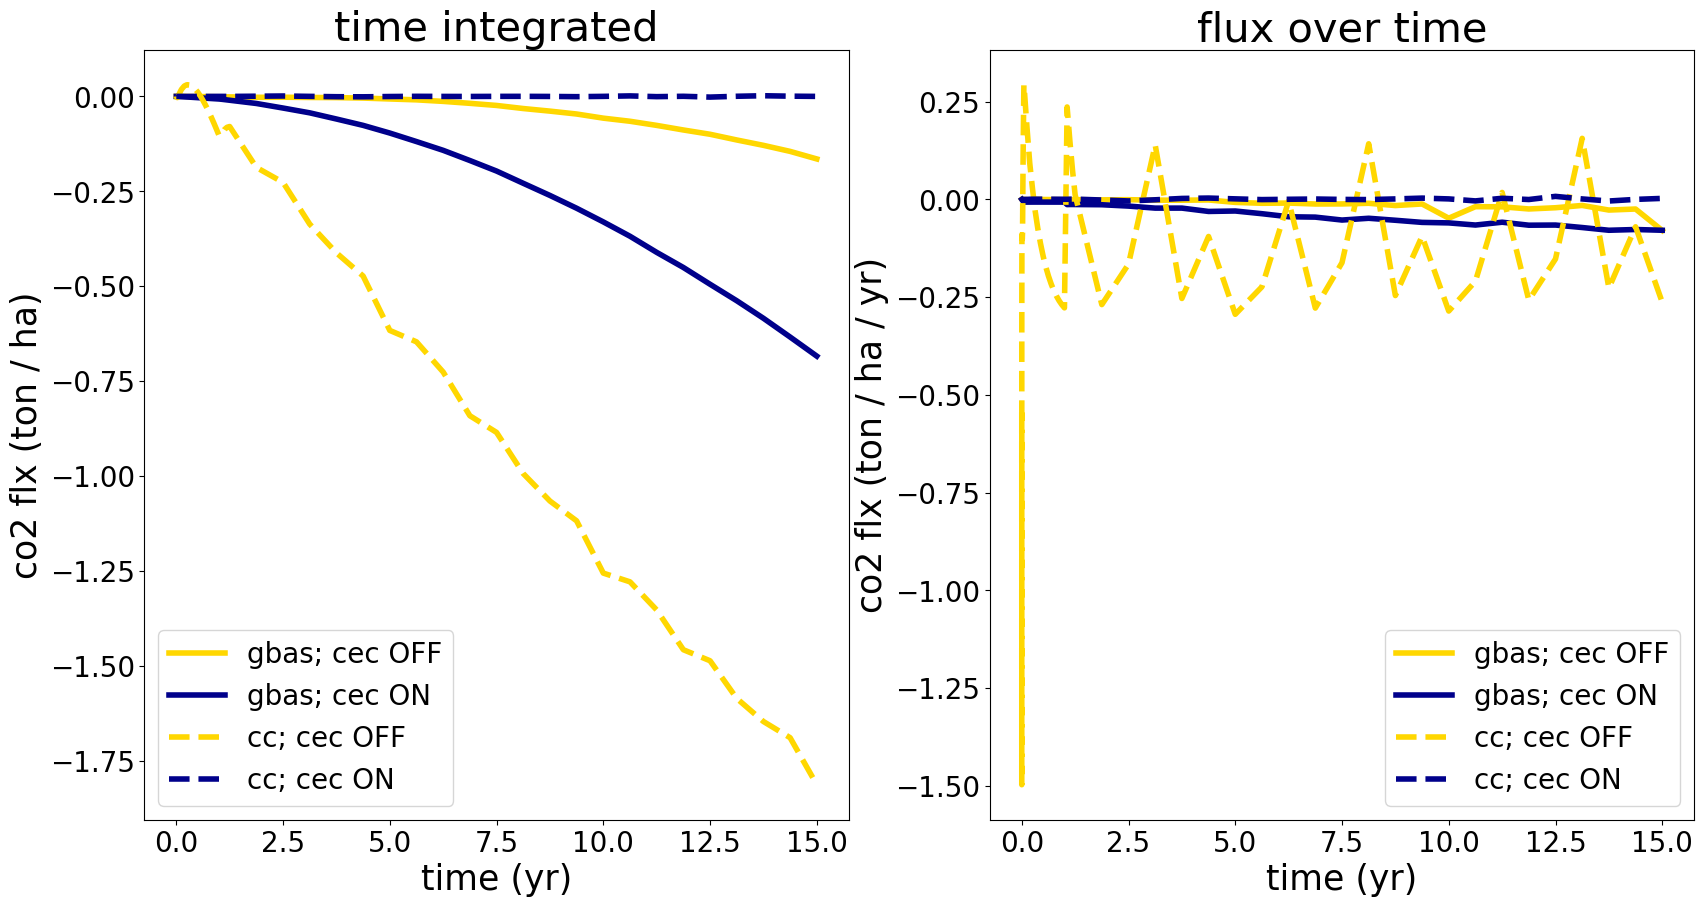

In [41]:
# --- CDR dif minus respiration over time 
# 
# [ ADV: higher values = more CDR (positive = flux out of soil column) ]
# [ DIF: lower values = more CDR (positive = flux out of soil to atm) ]
#
# *****************************
# --- plot aesthetics
include_titles = True
lwds = 4  # linewidths
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
# color limits
cmin, cmax = 0,100
cbar_extend = "both"    # both, max, or min
# axis limits
# xmin, xmax = (2 if logX else 0), 15
# ymin, ymax = 0.5, 0
# *****************************

# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=1, hspace=0.2, width_ratios=[1.0, 1.0])
plt.figure(figsize=(20,10))

# integrated flux
ax = plt.subplot(spec[0])
# [ BASALT ]
plt.plot(df_off_int1['time'], df_off_int1['co2flx_dif'] - df_off_int1['co2flx_resp'], 
        label = f'{this_fs1}; cec OFF', linewidth=lwds, c='gold')
plt.plot(df_on_int1['time'], df_on_int1['co2flx_dif'] - df_on_int1['co2flx_resp'], 
        label = f'{this_fs1}; cec ON', linewidth=lwds, c='darkblue')
# [ AGLIME ]
plt.plot(df_off_int2['time'], df_off_int2['co2flx_dif'] - df_off_int2['co2flx_resp'], 
        label = f'{this_fs2}; cec OFF', linewidth=lwds, linestyle='--', c='gold')
plt.plot(df_on_int2['time'], df_on_int2['co2flx_dif'] - df_on_int2['co2flx_resp'], 
        label = f'{this_fs2}; cec ON', linewidth=lwds, linestyle='--', c='darkblue')
plt.xlabel("time (yr)", fontsize = fs_xlab)
plt.ylabel("co2 flx (ton / ha)", fontsize = fs_xlab)
(plt.title("time integrated", fontsize=fs_title) if include_titles else "")
plt.tick_params(axis='both', labelsize=fs_tick)
plt.legend(fontsize=fs_tick)

# flux
ax = plt.subplot(spec[1])
# [ BASALT ]
plt.plot(df_off_flx1['time'], df_off_flx1['co2flx_dif'] - df_off_flx1['co2flx_resp'], 
        label = f'{this_fs1}; cec OFF', linewidth=lwds, c='gold')
plt.plot(df_on_flx1['time'], df_on_flx1['co2flx_dif'] - df_on_flx1['co2flx_resp'], 
        label = f'{this_fs1}; cec ON', linewidth=lwds, c='darkblue')
# [ AGLIME ]
plt.plot(df_off_flx2['time'], df_off_flx2['co2flx_dif'] - df_off_flx2['co2flx_resp'], 
        label = f'{this_fs2}; cec OFF', linewidth=lwds, linestyle='--', c='gold')
plt.plot(df_on_flx2['time'], df_on_flx2['co2flx_dif'] - df_on_flx2['co2flx_resp'], 
        label = f'{this_fs2}; cec ON', linewidth=lwds, linestyle='--', c='darkblue')
plt.xlabel("time (yr)", fontsize = fs_xlab)
plt.ylabel("co2 flx (ton / ha / yr)", fontsize = fs_xlab)
(plt.title("flux over time", fontsize=fs_title) if include_titles else "")
plt.tick_params(axis='both', labelsize=fs_tick)
plt.legend(fontsize=fs_tick)


# Read in cation data from a selected run to get timeseries fluxes

In [2]:
# --- read in data
this_fs1 = "gbas"
this_fs2 = "cc"

apprate = "1000p0"
dustrad = "200"

cecoff = "basev1"
cecon = "basev3a"
tauoff = 15
tauon = 15

cecON_dirname1 = f'hiFert_{this_fs1}_{cecon}_site_311a_app_{apprate}_psize_{dustrad}_{this_fs1}_field_tau{tauon}p0'
cecOFF_dirname1 = f'hiFert_{this_fs1}_{cecoff}_site_311a_app_{apprate}_psize_{dustrad}_{this_fs1}_field_tau{tauoff}p0'

cecON_dirname2 = f'hiFert_{this_fs2}_{cecon}_site_311a_app_{apprate}_psize_{dustrad}_{this_fs2}_field_tau{tauon}p0'
cecOFF_dirname2 = f'hiFert_{this_fs2}_{cecoff}_site_311a_app_{apprate}_psize_{dustrad}_{this_fs2}_field_tau{tauoff}p0'

outdir = "s3://carbonplan-carbon-removal/SCEPTER/scepter_output_scratch/"
subdir = "postproc_flxs"
fn = "cationflx_sum.pkl"

df_on1 = pd.read_pickle(os.path.join(outdir, cecON_dirname1, subdir, fn))
df_off1 = pd.read_pickle(os.path.join(outdir, cecOFF_dirname1, subdir, fn))

df_on2 = pd.read_pickle(os.path.join(outdir, cecON_dirname2, subdir, fn))
df_off2 = pd.read_pickle(os.path.join(outdir, cecOFF_dirname2, subdir, fn))

In [3]:
# --- read in control
this_fs1 = "gbas"
this_fs2 = "cc"

apprate = "0p0"
dustrad = "1"

cecON_dirname1ctrl = f'hiFert_{this_fs1}_{cecon}_site_311a_app_{apprate}_psize_{dustrad}_{this_fs1}_field_tau{tauon}p0'
cecOFF_dirname1ctrl = f'hiFert_{this_fs1}_{cecoff}_site_311a_app_{apprate}_psize_{dustrad}_{this_fs1}_field_tau{tauoff}p0'

cecON_dirname2ctrl = f'hiFert_{this_fs2}_{cecon}_site_311a_app_{apprate}_psize_{dustrad}_{this_fs2}_field_tau{tauon}p0'
cecOFF_dirname2ctrl = f'hiFert_{this_fs2}_{cecoff}_site_311a_app_{apprate}_psize_{dustrad}_{this_fs2}_field_tau{tauoff}p0'

outdir = "s3://carbonplan-carbon-removal/SCEPTER/scepter_output_scratch/"
subdir = "postproc_flxs"
fn = "cationflx_sum.pkl"

df_on1ctrl = pd.read_pickle(os.path.join(outdir, cecON_dirname1ctrl, subdir, fn))
df_off1ctrl = pd.read_pickle(os.path.join(outdir, cecOFF_dirname1ctrl, subdir, fn))

df_on2ctrl = pd.read_pickle(os.path.join(outdir, cecON_dirname2ctrl, subdir, fn))
df_off2ctrl = pd.read_pickle(os.path.join(outdir, cecOFF_dirname2ctrl, subdir, fn))

In [4]:
# --- SUBTRACT CONTROL? 
subtract_ctrl = True

if subtract_ctrl:
    # identify numeric cols
    numeric_cols = df_on1.select_dtypes(include="number").columns.difference(["time"])
    timecol_on = df_on1[['time']].copy()
    timecol_off = df_off1[['time']].copy()
    flxtypecol = df_on1[['flx_type']].copy()
    # [fs 1]
    df_on1 = df_on1[numeric_cols].subtract(df_on1ctrl[numeric_cols]).copy()
    df_on1['time'] = timecol_on.copy()
    df_on1['flx_type'] = flxtypecol.copy()

    df_off1 = df_off1[numeric_cols].subtract(df_off1ctrl[numeric_cols]).copy()
    df_off1['time'] = timecol_off.copy()
    df_off1['flx_type'] = flxtypecol.copy()
    # [fs 2]
    df_on2 = df_on2[numeric_cols].subtract(df_on2ctrl[numeric_cols]).copy()
    df_on2['time'] = timecol_on.copy()
    df_on2['flx_type'] = flxtypecol.copy()

    df_off2 = df_off2[numeric_cols].subtract(df_off2ctrl[numeric_cols]).copy()
    df_off2['time'] = timecol_off.copy()
    df_off2['flx_type'] = flxtypecol.copy()

In [5]:
# --- confirm mass balance
#     [ GOOD ENOUGH ! ]
# we should have: [adv + tflx + sources + dif = 0]
# df_off1 = df_off1.assign(mass_balance_check = df_off1['co2flx_adv'] + df_off1['co2flx_tflx'] + df_off1['co2flx_dif'] + df_off1['co2flx_resp'] + df_off1['co2flx_inorg'])
# df_on1 = df_on1.assign(mass_balance_check = df_on1['co2flx_adv'] + df_on1['co2flx_tflx'] + df_on1['co2flx_dif'] + df_on1['co2flx_resp'] + df_on1['co2flx_inorg'])
# df_off2 = df_off2.assign(mass_balance_check = df_off2['co2flx_adv'] + df_off2['co2flx_tflx'] + df_off2['co2flx_dif'] + df_off2['co2flx_resp'] + df_off2['co2flx_inorg'])
# df_on2 = df_on2.assign(mass_balance_check = df_on2['co2flx_adv'] + df_on2['co2flx_tflx'] + df_on2['co2flx_dif'] + df_on2['co2flx_resp'] + df_on2['co2flx_inorg'])

# separate integrated and regular fluxes
# [ basalt ]
df_off_int1 = df_off1[df_off1['flx_type'] == "int_flx"]
df_on_int1 = df_on1[df_on1['flx_type'] == "int_flx"]
df_off_flx1 = df_off1[df_off1['flx_type'] == "flx"]
df_on_flx1 = df_on1[df_on1['flx_type'] == "flx"]

df_off_int2 = df_off2[df_off2['flx_type'] == "int_flx"]
df_on_int2 = df_on2[df_on2['flx_type'] == "int_flx"]
df_off_flx2 = df_off2[df_off2['flx_type'] == "flx"]
df_on_flx2 = df_on2[df_on2['flx_type'] == "flx"]


# plt.plot(df_on_int['time'], df_on_int['mass_balance_check'], label='cec on')
# plt.plot(df_off_int['time'], df_off_int['mass_balance_check'], label='cec off')
# plt.legend()

In [49]:
df_on_flx2

,adv_charge,carbsld_source_charge,co2pot_adv_tonHa,co2pot_adv_tonHaYr,co2pot_tot_tonHa,co2pot_tot_tonHaYr,noncarbsld_source_charge,tflx_charge,time,flx_type
0,7.415002e-11,-0.000027,NaN,-0.000006,NaN,0.000006,-1.647397e-14,0.000027,0.000126,flx
1,2.262099e-10,-0.000028,NaN,-0.000006,NaN,0.000006,-4.983381e-14,0.000028,0.000376,flx
2,7.911449e-10,-0.000029,NaN,-0.000006,NaN,0.000006,-1.738165e-13,0.000029,0.001251,flx
3,2.667540e-09,-0.000034,NaN,-0.000007,NaN,0.000007,-5.810224e-13,0.000034,0.003751,flx
4,4.918762e-09,-0.000040,NaN,-0.000009,NaN,0.000009,-1.052809e-12,0.000040,0.006251,flx
...,...,...,...,...,...,...,...,...,...,...
59,-1.402116e-01,-0.023650,NaN,-0.066911,NaN,0.005204,1.847372e-08,0.163862,12.500001,flx
60,1.253456e-02,-0.001980,NaN,0.005081,NaN,0.000436,-4.689974e-09,-0.010554,13.125001,flx
61,-7.639464e-03,0.009023,NaN,-0.001377,NaN,-0.001986,1.029456e-08,-0.001384,13.750001,flx
62,-7.168056e-03,0.001336,NaN,-0.002861,NaN,-0.000294,4.356355e-09,0.005832,14.375001,flx


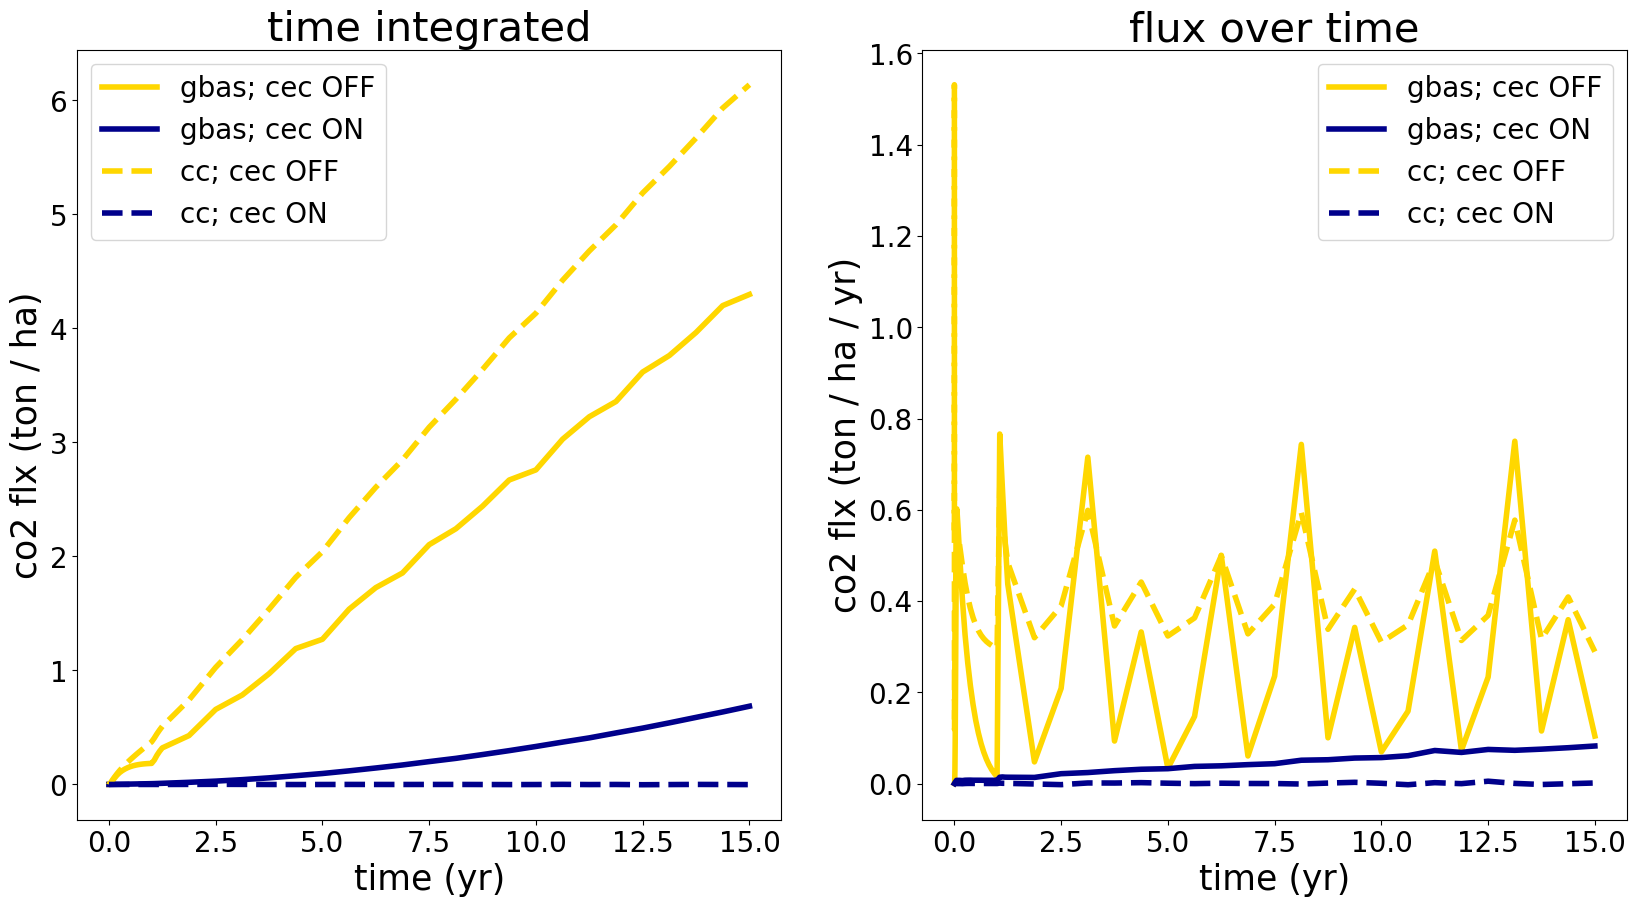

In [7]:
# --- CDR individual fluxes
pvar_flx = "co2pot_tot_tonHaYr"
pvar_int = "co2pot_tot_tonHa"
# 
# [ ADV: higher values = more CDR (positive = flux out of soil column) ]
# [ DIF: lower values = more CDR (positive = flux out of soil to atm) ]
#
# *****************************
# --- plot aesthetics
include_titles = True
lwds = 4  # linewidths
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
# color limits
cmin, cmax = 0,100
cbar_extend = "both"    # both, max, or min
# axis limits
# xmin, xmax = (2 if logX else 0), 15
# ymin, ymax = 0.5, 0
# *****************************

# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=1, hspace=0.2, width_ratios=[1.0, 1.0])
plt.figure(figsize=(20,10))

# integrated flux
ax = plt.subplot(spec[0])
# [ BASALT ]
plt.plot(df_off_int1['time'], df_off_int1[pvar_int], 
        label = f'{this_fs1}; cec OFF', linewidth=lwds, c='gold')
plt.plot(df_on_int1['time'], df_on_int1[pvar_int], 
        label = f'{this_fs1}; cec ON', linewidth=lwds, c='darkblue')
# [ AGLIME ]
plt.plot(df_off_int2['time'], df_off_int2[pvar_int], 
        label = f'{this_fs2}; cec OFF', linewidth=lwds, linestyle='--', c='gold')
plt.plot(df_on_int2['time'], df_on_int2[pvar_int], 
        label = f'{this_fs2}; cec ON', linewidth=lwds, linestyle='--', c='darkblue')
plt.xlabel("time (yr)", fontsize = fs_xlab)
plt.ylabel("co2 flx (ton / ha)", fontsize = fs_xlab)
(plt.title("time integrated", fontsize=fs_title) if include_titles else "")
plt.tick_params(axis='both', labelsize=fs_tick)
plt.legend(fontsize=fs_tick)

# flux
ax = plt.subplot(spec[1])
# [ BASALT ]
plt.plot(df_off_flx1['time'], df_off_flx1[pvar_flx], 
        label = f'{this_fs1}; cec OFF', linewidth=lwds, c='gold')
plt.plot(df_on_flx1['time'], df_on_flx1[pvar_flx], 
        label = f'{this_fs1}; cec ON', linewidth=lwds, c='darkblue')
# [ AGLIME ]
plt.plot(df_off_flx2['time'], df_off_flx2[pvar_flx], 
        label = f'{this_fs2}; cec OFF', linewidth=lwds, linestyle='--', c='gold')
plt.plot(df_on_flx2['time'], df_on_flx2[pvar_flx], 
        label = f'{this_fs2}; cec ON', linewidth=lwds, linestyle='--', c='darkblue')
plt.xlabel("time (yr)", fontsize = fs_xlab)
plt.ylabel("co2 flx (ton / ha / yr)", fontsize = fs_xlab)
(plt.title("flux over time", fontsize=fs_title) if include_titles else "")
plt.tick_params(axis='both', labelsize=fs_tick)
plt.legend(fontsize=fs_tick)


In [ ]:
# --------